In [3]:
import requests
import json
import datetime as dt
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ruptures as rpt
from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import statsmodels
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

In [116]:
# plotting options
%matplotlib inline
sns.set_style('whitegrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)
figsize1 = (17,6)
figsize2 = (17,4)
figsize3 = (17,3)
dpi=200
title_fontsize=16
ax_fontsize=12

# Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
    - [EDA](#eda)
3. [Modeling](#modeling)
    - [ARIMA](#arima)
    - [ANN](#ann)

<a id='introduction'></a>
# 1. Introduction

- Research Question
    - Forecast Ethereum (ETH) price
    - First using time series only, then see if can improve by including exogenous variables    
- Method
    - Collect data using APIs
    - Perform EDA on target variable: ETH close price
    - 
    
    
    - Design of the experiment
    - Evaluation
    - Benchmarks

<a id='data'></a>
# 2. Data

## 2.1 Data Access & Preprocessing
- Functions to make API calls
- Get desired eth & exogenous variable data (for use in second part of analysis)
- Clean/combine into single df to draw from throughout analysis

In [ ]:
def cryptocompare_data(symbol,
                       comparison_symbol='USD',
                       all_data=True,
                       rows=1,
                       aggregate=1,
                       write_to=False):
    
    # symbol = symbol of desired coin
    # comparison symbol = symbol for currency to price with
    # to subset data, set all_data to false, then specificy with rows parameter
    # write_to = write dataframe to supported filetype: csv, json, pkl
    
    # api call
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(),
                    comparison_symbol.upper(),
                    rows,
                    aggregate)
    
    if all_data:
        url += '&allData=true'
    
    # store in dataframe
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['date'] = [dt.datetime.fromtimestamp(d) for d in df.time]
    df['date'] = df.date.dt.date
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.drop('time', axis=1, inplace=True)
    df = df[['date', 'open', 'high', 'low', 'close', 'volumefrom', 'volumeto']]
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # write to file option
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = symbol.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df
    
def fred_data(series_id,
              api_key,
              file_type='json',
              frequency='d',
              raw=False,
              write_to=False):
    
    # series_id = string, symbol from fred
    # filetype options: xml, json, txt, xls
    # frequency options: d = daily, w = weekly, bw = biweekly
    # m = monthly, q = quarterly, sa = semiannual, a = annual
    # raw=True will skip the preprocessing and return the raw data
    # write_to=write dataframe to supported filetype: csv, json, pkl
    
    url = 'https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type={}&frequency={}'\
                  .format(series_id,
                          api_key,
                          file_type,
                          frequency)
    
    response = requests.get(url)
    data = response.json()['observations']
    df = pd.DataFrame(data)
    
    if raw is False:
        df.drop(['realtime_end', 'realtime_start'], axis=1, inplace=True)
        df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
        df.rename(columns={'value':series_id.lower()}, inplace=True)
        
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = series_id.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df

def write_df(df, write_to, filename):
    if write_to == 'csv':
        df.to_csv('{}'.format(filename), index=False)
    elif write_to == 'pkl':
        df.to_pickle('{}'.format(filename))
    elif write_to == 'json':
        df.to_json('{}'.format(filename), orient='split')
    else:
        print('function does not support writing to {}'.format(write_to))
        print('format filetype as shown (string in all lower case)')
        print('supported filetypes: csv, json, pkl')
        
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [ ]:
# get coin data
coins = ['ETH', 'BTC', 'XRP', 'EOS', 'LTC', 'XLM', 'XMR']

# create empty df for each coin
coins_d = {coin.lower(): pd.DataFrame() for coin in coins}

# populate coin dfs with respective coin data
for key, df in coins_d.items():
    coins_d[key] = cryptocompare_data(symbol=key)

# add coin names to columns & preview dfs
for key, df in coins_d.items():
    cols_orig = list(coins_d[key].columns)[1:]
    cols_new = ['date']
    for col in cols_orig:
        cols_new.append('{}_{}'.format(key, col))
    coins_d[key].columns = cols_new
    coins_d[key].set_index('date', inplace=True, drop=True)
    #display(coins_d[key].head(1))
    
# combine to single df
coins_df = pd.concat([df for key, df in coins_d.items()], axis=1)
display(coins_df.head(1))

# convert keys:values to variables = assignments
#locals().update(coins_d)

In [ ]:
# get fred data
fred_apikey = get_file_contents('fred_apikey')

indices = {
    'VIXCLS':'d', # cboe volatility index
    'TWEXB':'w', # trade weighted usd index
    'EFFR':'d' # effective federal funds rate
    }

# create empty df for each index
indices_d = {index: pd.DataFrame() for index in indices}

# populate dfs with index data
for key in set(indices.keys()) and set(indices_d.keys()):
    indices_d[key] = fred_data(series_id=key,
                               api_key=fred_apikey,
                               frequency = indices[key])
    indices_d[key].set_index('date', inplace=True, drop=True)

# lowercase dict keys, preview dfs
indices_d =  {key.lower(): value for key, value in indices_d.items()}

#for key, df in indices_d.items():
#    display(df.head(1))

# combine to single df    
fred_df = pd.concat([df for key, df in indices_d.items()], axis=1)
display(fred_df.head(1))

# convert to variables = assignments
#locals().update(indices_d)

In [ ]:
# combine data into single df
df_alldata = pd.concat([coins_df, fred_df], axis=1)

# replace '.' with nan so ffill will catch everything
# '.' denotes a holiday
df_alldata.replace('.', np.nan, inplace=True)

# ffill values for weekends skipped by traditional indices
df_alldata.ffill(inplace=True)

# start dataframe at beginning of ethereum
df = df_alldata[df_alldata.eth_close.isnull().sum():]
display(df.head(3))

# check missingness
for col in df.columns:
    if df['{}'.format(col)].isnull().any() == True:
        print(col)

In [ ]:
df.to_json('df.json', orient='split')

**Note**: EOS & XLM currencies started after ETH (hence their missing values). Will address this later when dealing with exogenous variables

<a id='eda'></a>
## 2.2 Time Series EDA

In [135]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close).copy()
display(ts.head(3))
display(ts.tail(3))

,eth_close
2015-08-06,3.0
2015-08-07,1.2
2015-08-08,1.2


,eth_close
2018-10-09,225.26
2018-10-10,189.86
2018-10-11,190.92


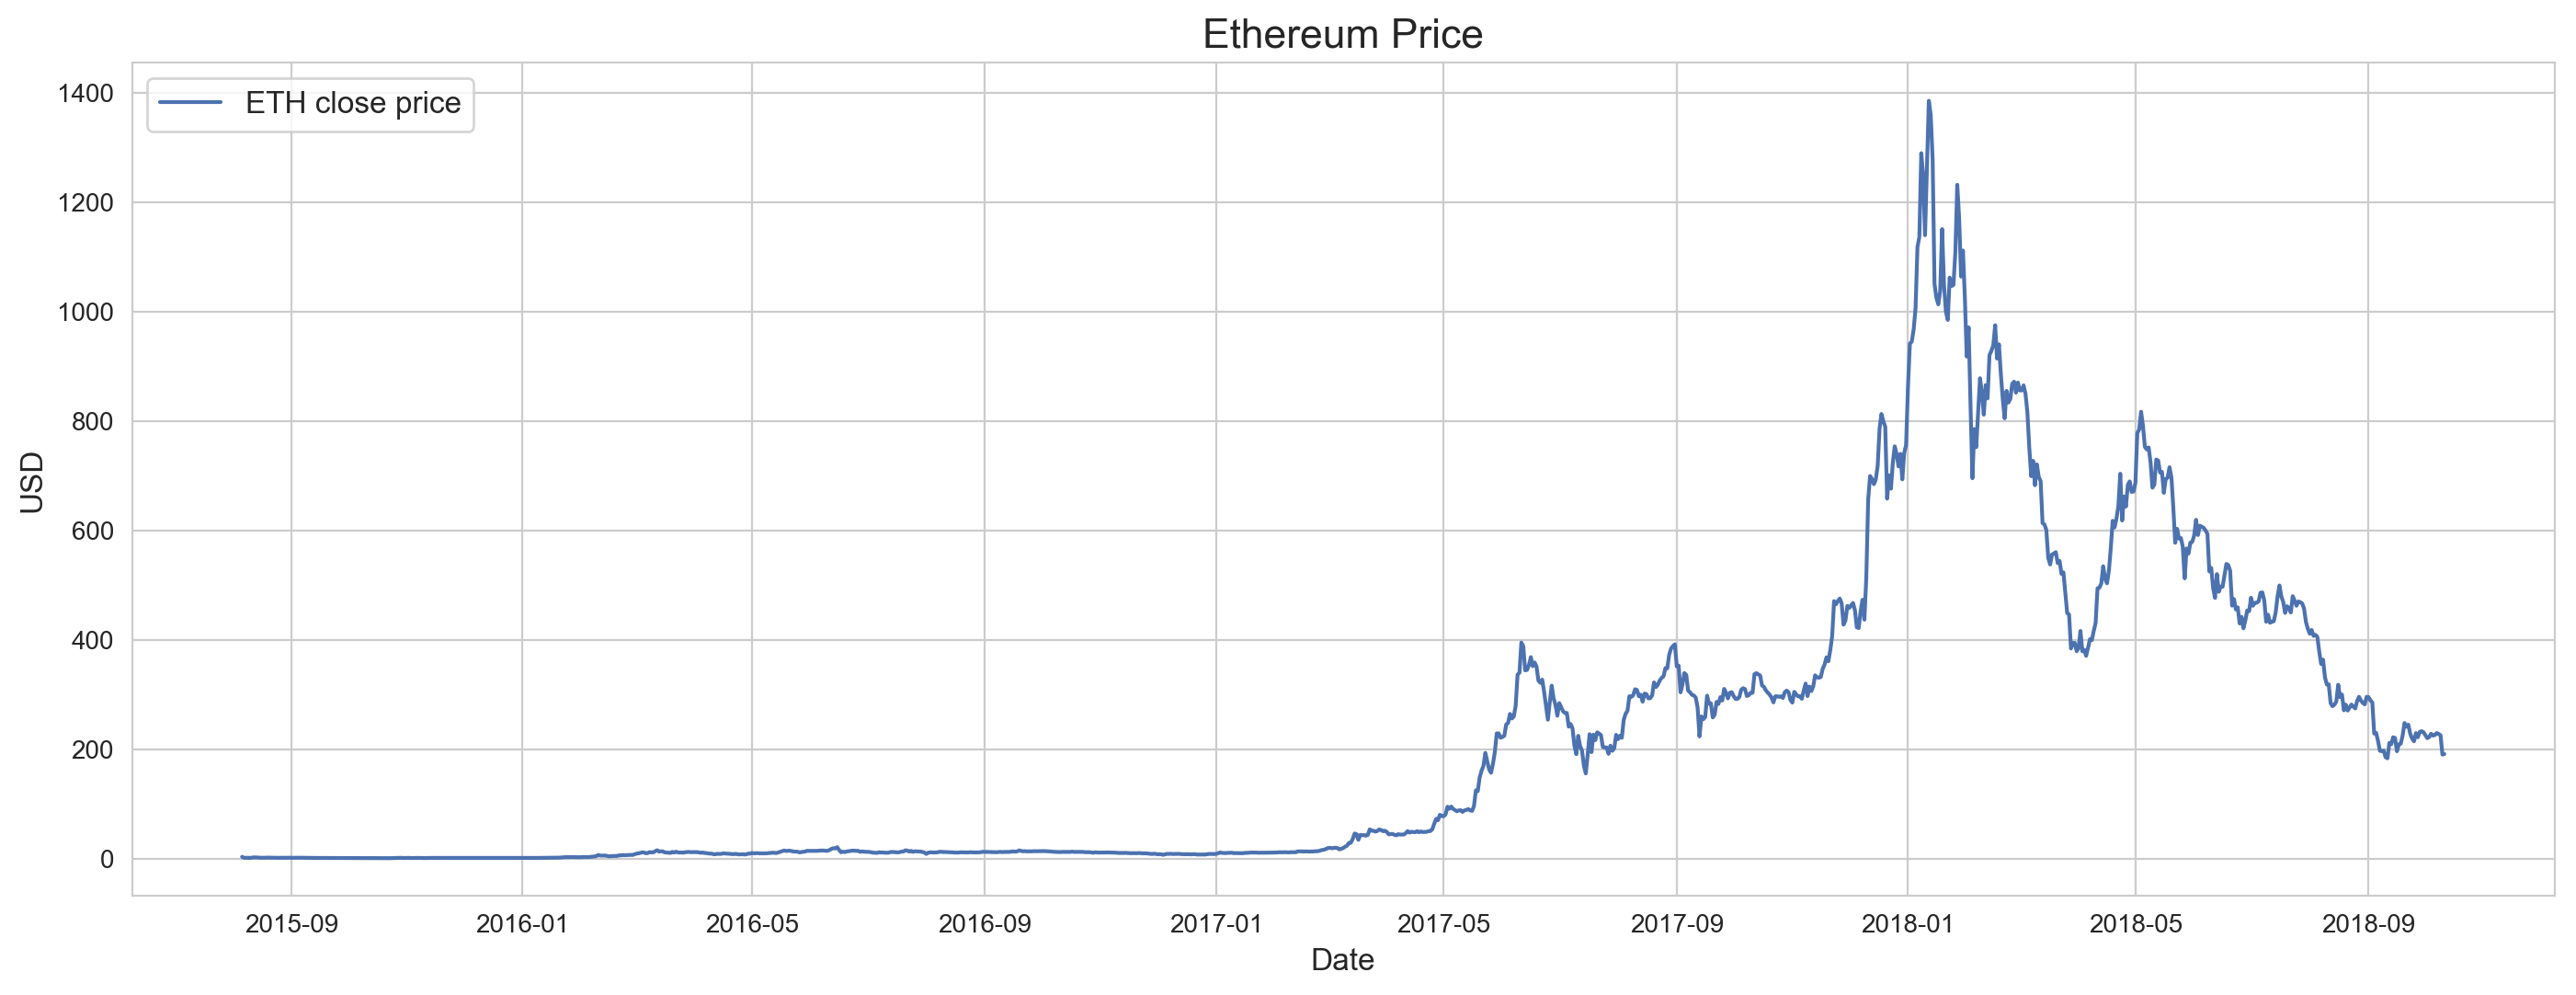

Augmented Dickey-Fuller Test Results:
adf: -1.825900342003136
pval: 0.36768080552143656
critical vals {'1%': -3.4361042569951805, '5%': -2.8640808675675826, '10%': -2.568122823703617}


In [136]:
fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.plot(
    ts.index.values,
    ts.eth_close,
    label="ETH close price",
    color=colors[0]
)
ax.set_title("Ethereum Price", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.legend(loc='upper left', prop={'size':ax_fontsize})
plt.show()

print("Augmented Dickey-Fuller Test Results:")
print("adf: {0}\npval: {1}\ncritical vals {2}".format(
    adfuller(ts.eth_close)[0],
    adfuller(ts.eth_close)[1],
    adfuller(ts.eth_close)[4]))

**Interpretation:**
- Data displays trend(s), ADF test confirms non-stationarity
- Data does not appear to have a seasonality component
- Graph indicates presence of structural breaks

**To do:**
- Perform change point analysis
- Get stationary time series

### 2.2.1 Change point analysis
- Potential side aspect: compare change point analysis by fbprophet to ruptures
    - FBProphet is automatic but designed for seasonal data which this is not
    - Ruptures requires more setup but is more flexible, may result in better analysis if set up properly
        - PELT: Pruned Exact Linear Time

In [137]:
# estimate changepoints with ruptures
cpts_ruptures = rpt.Pelt(model='rbf').fit_predict(ts, pen=10)

print("Predicted by PELT:\n{}".format(cpts_ruptures))

# do the same with fbprophet
ts_prophet = ts.copy().reset_index()
ts_prophet.columns = (['ds', 'y'])

m = Prophet().fit(ts_prophet)
#print(m.changepoints.index)

# populate df with changepoints
cpts_df = pd.DataFrame(
    {'index_locator':m.changepoints.index,
     'cpts_prophet':m.changepoints.values,
     'delta':m.params['delta'].mean(0)})
print("\nPredicted by Prophet:\n{}".format(list(m.changepoints.index)))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted by PELT:
[655, 835, 860, 880, 910, 950, 985, 1040, 1100, 1163]

Predicted by Prophet:
[37, 74, 111, 149, 186, 223, 260, 297, 334, 372, 409, 446, 483, 520, 557, 595, 632, 669, 706, 743, 780, 818, 855, 892, 929]


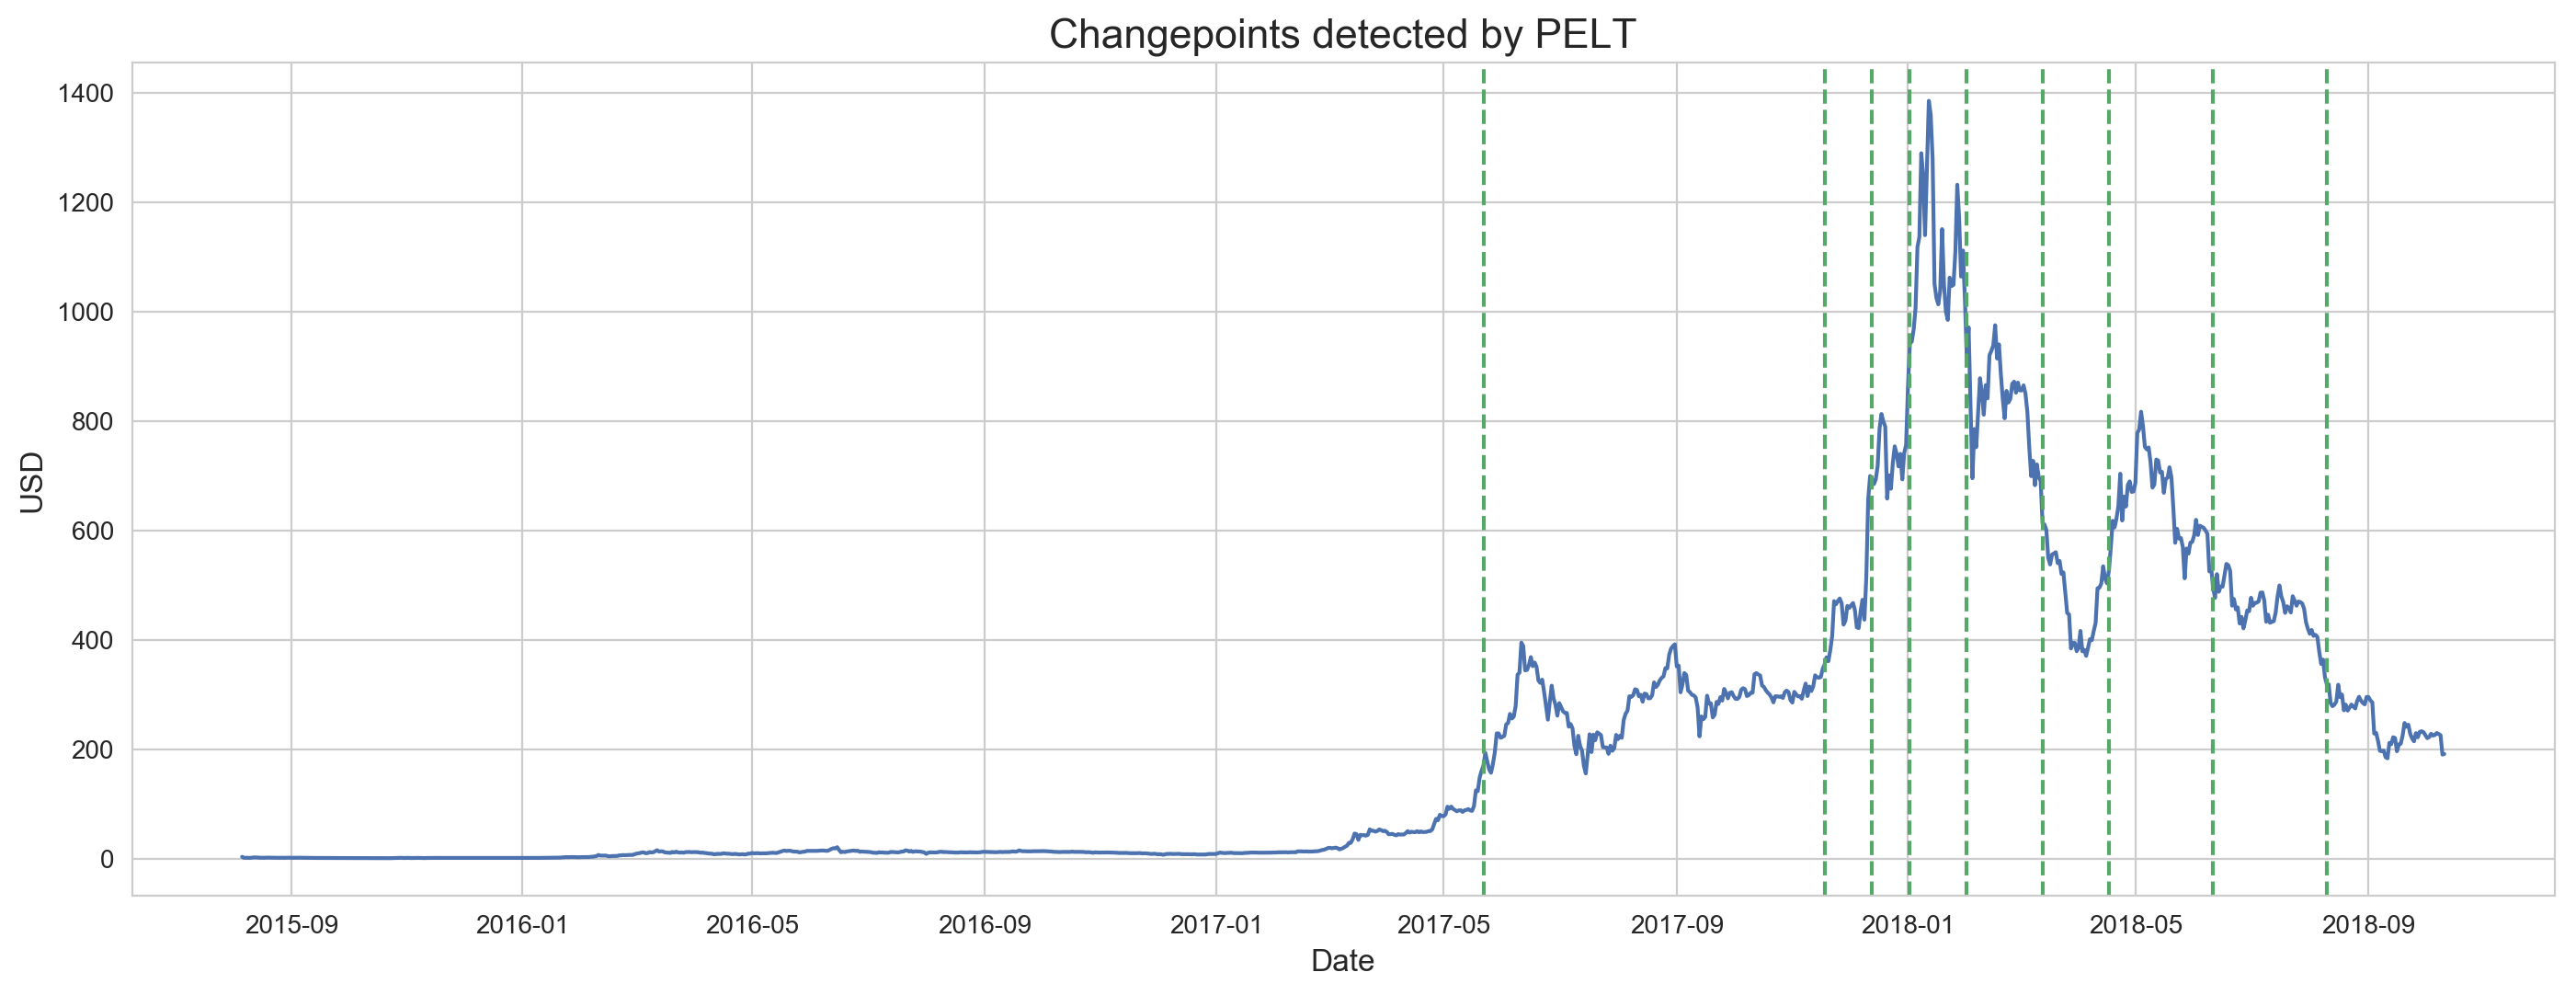

In [138]:
# plot PELT
fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
plt.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for pt in cpts_ruptures[:-1]:
    plt.axvline(
        x=ts.index.values[pt],
        color=colors[2],
        linewidth=1.5,
        linestyle='dashed'
    )
ax.set_title("Changepoints detected by PELT", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
plt.show()

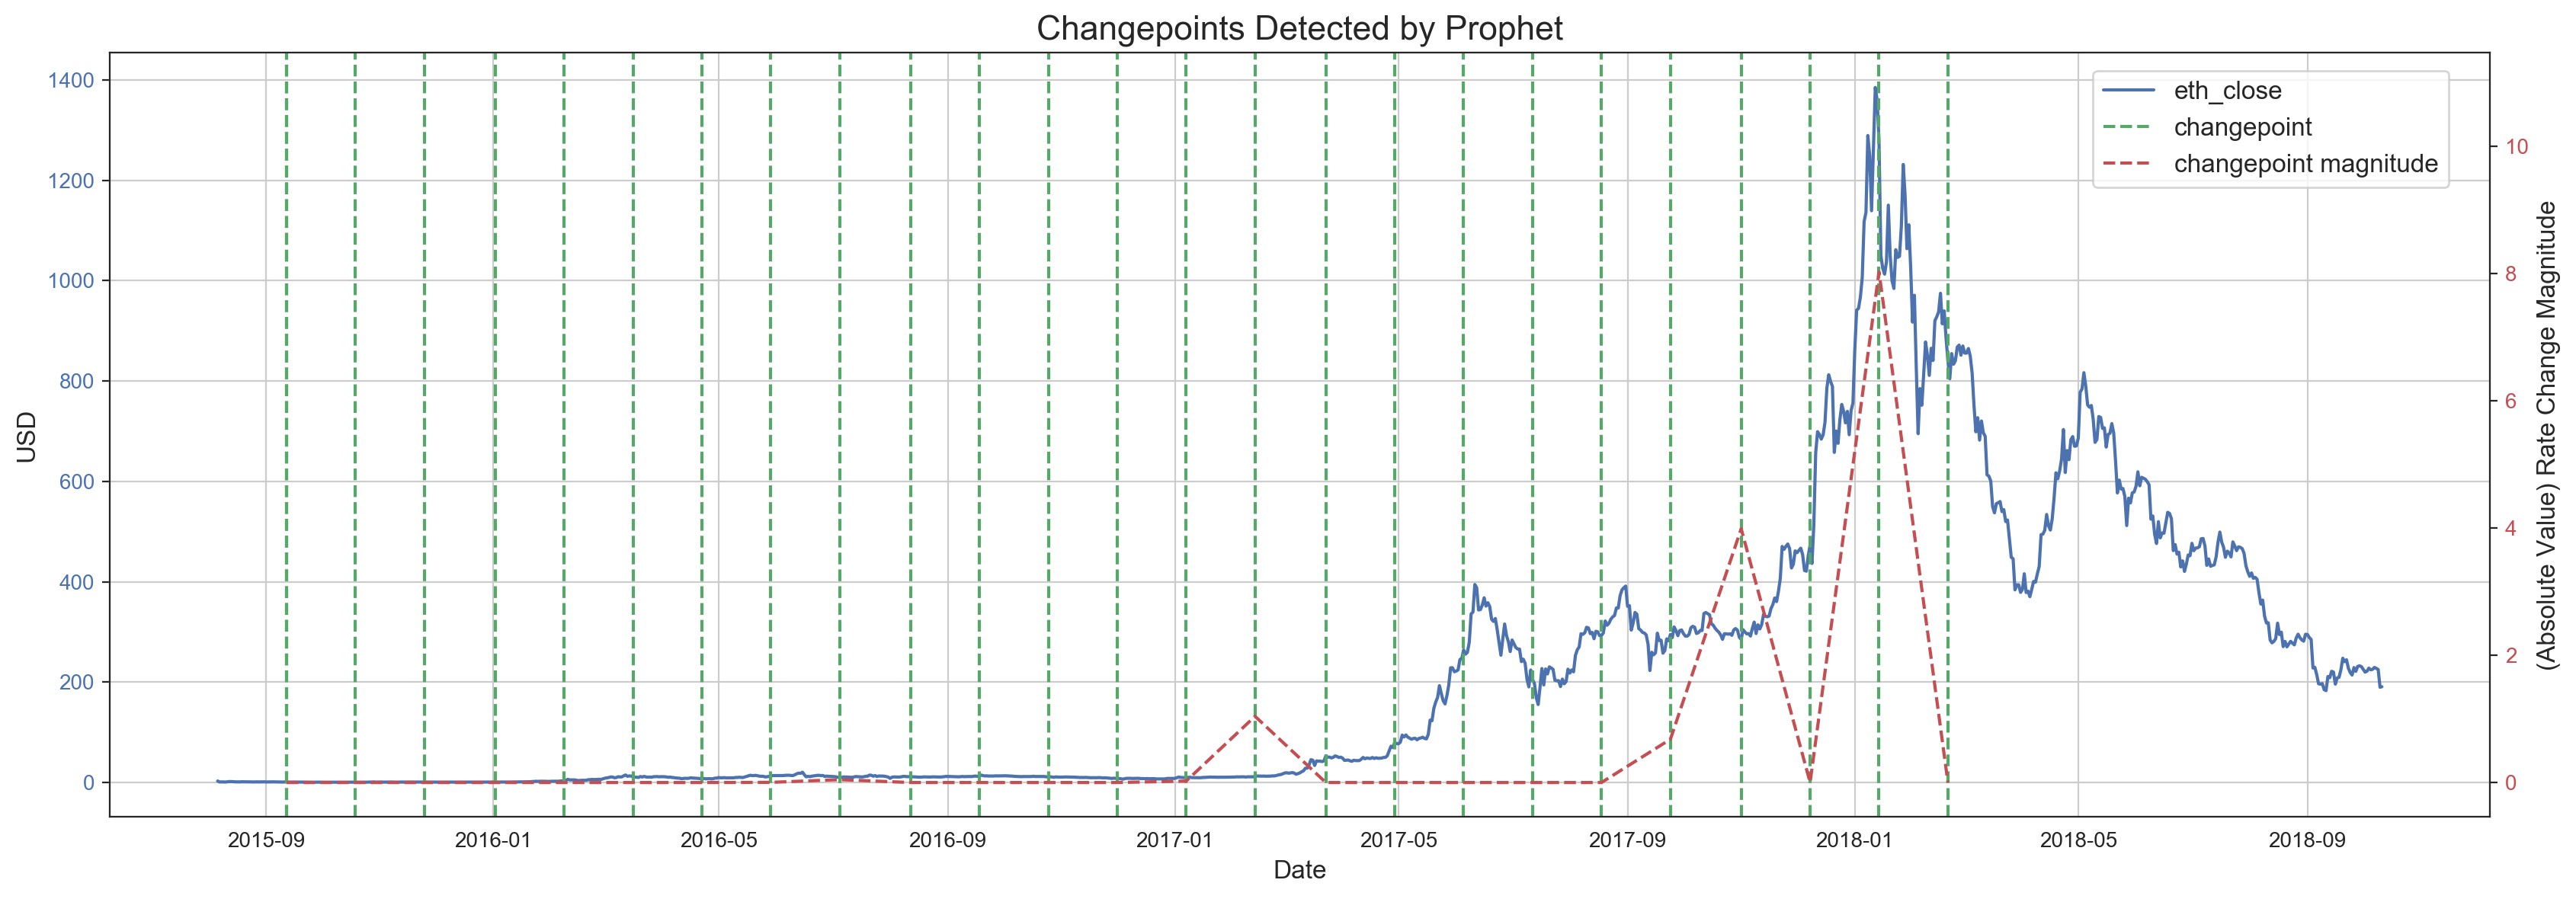

In [139]:
# plot prophet
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

fig, ax1 = plt.subplots(figsize=figsize1, dpi=dpi)
sns.set_style('ticks')
ax1.set_title('Changepoints Detected by Prophet', size=title_fontsize)
# eth price
ax1.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0],
)
for pt in list(cpts_df.index_locator):
    ax1.axvline(
        x=ts.index.values[pt],
        color=colors[2],
        linewidth=1.5,
        linestyle='dashed'
    )
ax1.axvline(
    x=ts.index.values[cpts_df.index_locator[0]],
    color=colors[2],
    label='changepoint',
    linewidth=1.5,
    linestyle='dashed'
)
ax1.set_ylabel("USD", size=ax_fontsize)
ax1.set_xlabel("Date", size=ax_fontsize)
ax1.tick_params(axis='y', labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("(Absolute Value) Rate Change Magnitude", size=ax_fontsize)
ax2.plot(
    cpts_df.cpts_prophet,
    abs(cpts_df.delta),
    label='changepoint magnitude',
    c=colors[3],
    linestyle='dashed')

ax2.tick_params(axis='y', labelcolor=colors[3])
ax2.set_ylim(min(cpts_df.delta), max(cpts_df.delta))
align_yaxis(ax1, 0, ax2, 0)

fig.legend(prop={'size':ax_fontsize}, bbox_to_anchor=(.95, .92))
fig.tight_layout()
plt.show()

In [140]:
# extract significant potential changepoints

delta_mean = np.mean(abs(cpts_df.delta))
cpts_prophet = []

for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] >= delta_mean:
        cpts_prophet.append(row.index_locator)
    elif cpts_df.delta[i] <= -delta_mean:
        cpts_prophet.append(row.index_locator)

print(cpts_prophet)
print(cpts_ruptures)

[557, 780, 818, 892]
[655, 835, 860, 880, 910, 950, 985, 1040, 1100, 1163]


In [141]:
break_points = cpts_prophet[0:2] + cpts_ruptures[:-1]
break_points.sort()
print("break points:\n{}".format(break_points))

break points:
[557, 655, 780, 835, 860, 880, 910, 950, 985, 1040, 1100]


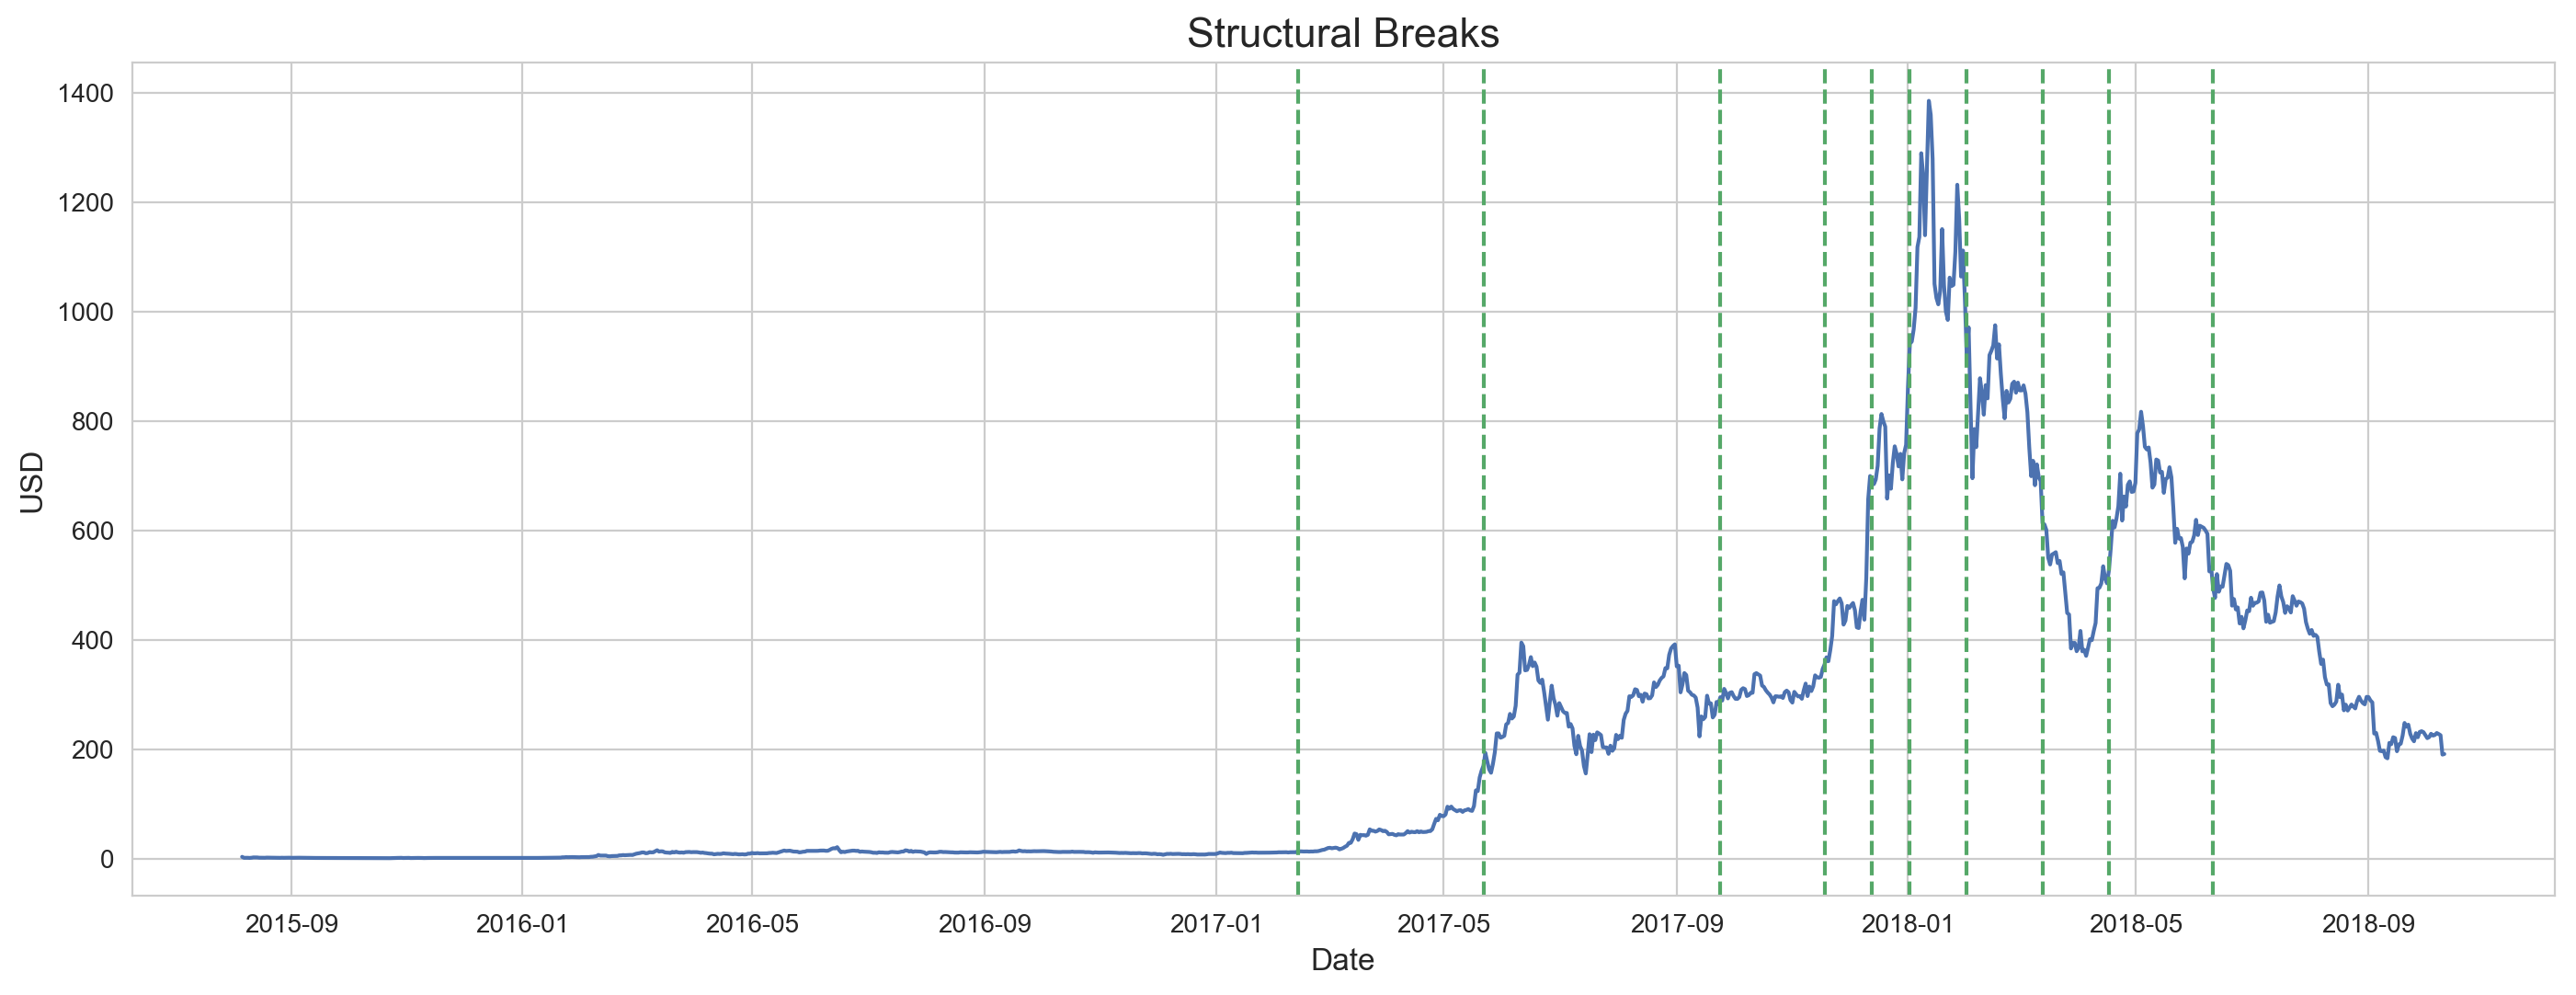

In [142]:
# plot final breakpoints
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
plt.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for pt in break_points[:-1]:
    plt.axvline(
        x=ts.index.values[pt],
        color=colors[2],
        linewidth=1.5,
        linestyle='dashed'
    )
ax.set_title("Structural Breaks", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
plt.show()

### 2.2.2 Window Size Selection

In [146]:
pt_diffs = []

for i, point in enumerate(break_points[:-1]):
    pt_diffs.append(break_points[i+1] - point)
    
pt_diffs.sort()
print("pt_diffs: {}".format(pt_diffs))
print("pt_diffs mean = {:.2f}".format(np.mean(pt_diffs)))

pt_diffs: [20, 25, 30, 35, 40, 55, 55, 60, 98, 125]
pt_diffs mean = 54.30


In [144]:
window = 54

### 2.2.3 Stationarity

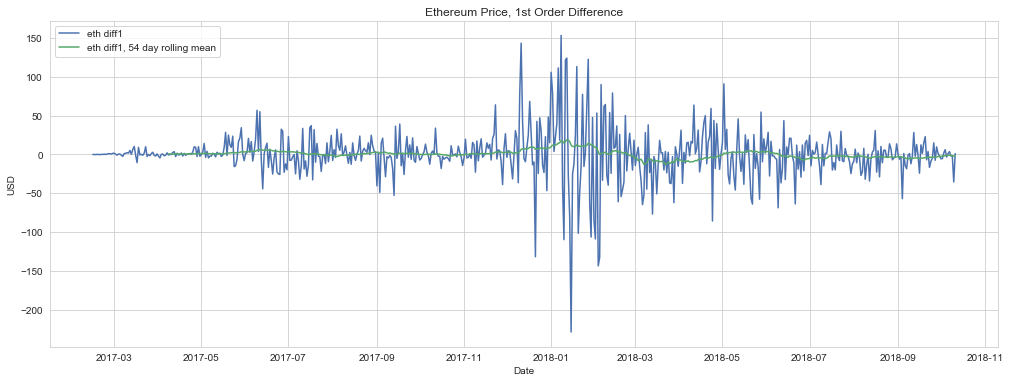

1st order differenced ADF test results

price:
adf -3.7220
pval 0.0038138191690575223
critical vals {'1%': -3.4415777369651717, '5%': -2.866493255736561, '10%': -2.569407951640003}

rolling mean:
adf -3.2091
pval 0.019461272555661092
critical vals {'1%': -3.442701754304053, '5%': -2.866988120523906, '10%': -2.5696716542766693}


In [145]:
# reset time series using first significant changepoint
ts = ts[break_points[0]:]
# first order difference
ts['diff1'] = diff(ts.eth_close, k_diff=1)

plt.figure(figsize=(figsize1))
plt.plot(
    ts.index.values[1:],
    ts.diff1[1:],
    label='eth diff1',
    color=colors[0]
)
plt.plot(
    ts.index.values[1:],
    ts.diff1[1:].rolling(window).mean(),
    label='eth diff1, {} day rolling mean'.format(window),
    color=colors[2]
)
#plt.plot(
#    ts.index.values[1:],
#    ts.diff1[1:].rolling(window).std(),
#    label='eth diff1, {} day rolling std dev'.format(window),
#    color=colors[1]
#)
plt.title('Ethereum Price, 1st Order Difference')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

# ADF Test
adf_diff1 = adfuller(ts.diff1.dropna())
adf_rm1 = adfuller(ts.diff1[1:].rolling(window).mean().dropna())

print('1st order differenced ADF test results')
print('\nprice:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_diff1[0], adf_diff1[1], adf_diff1[4]))
print('\nrolling mean:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_rm1[0], adf_rm1[1], adf_rm1[4]))

<a id='modeling'></a>
# 3. Modeling & Forecasting Time Series

<a id='arima'></a>
## 3.1 ARIMA
### 3.1.1 ACF/PACF

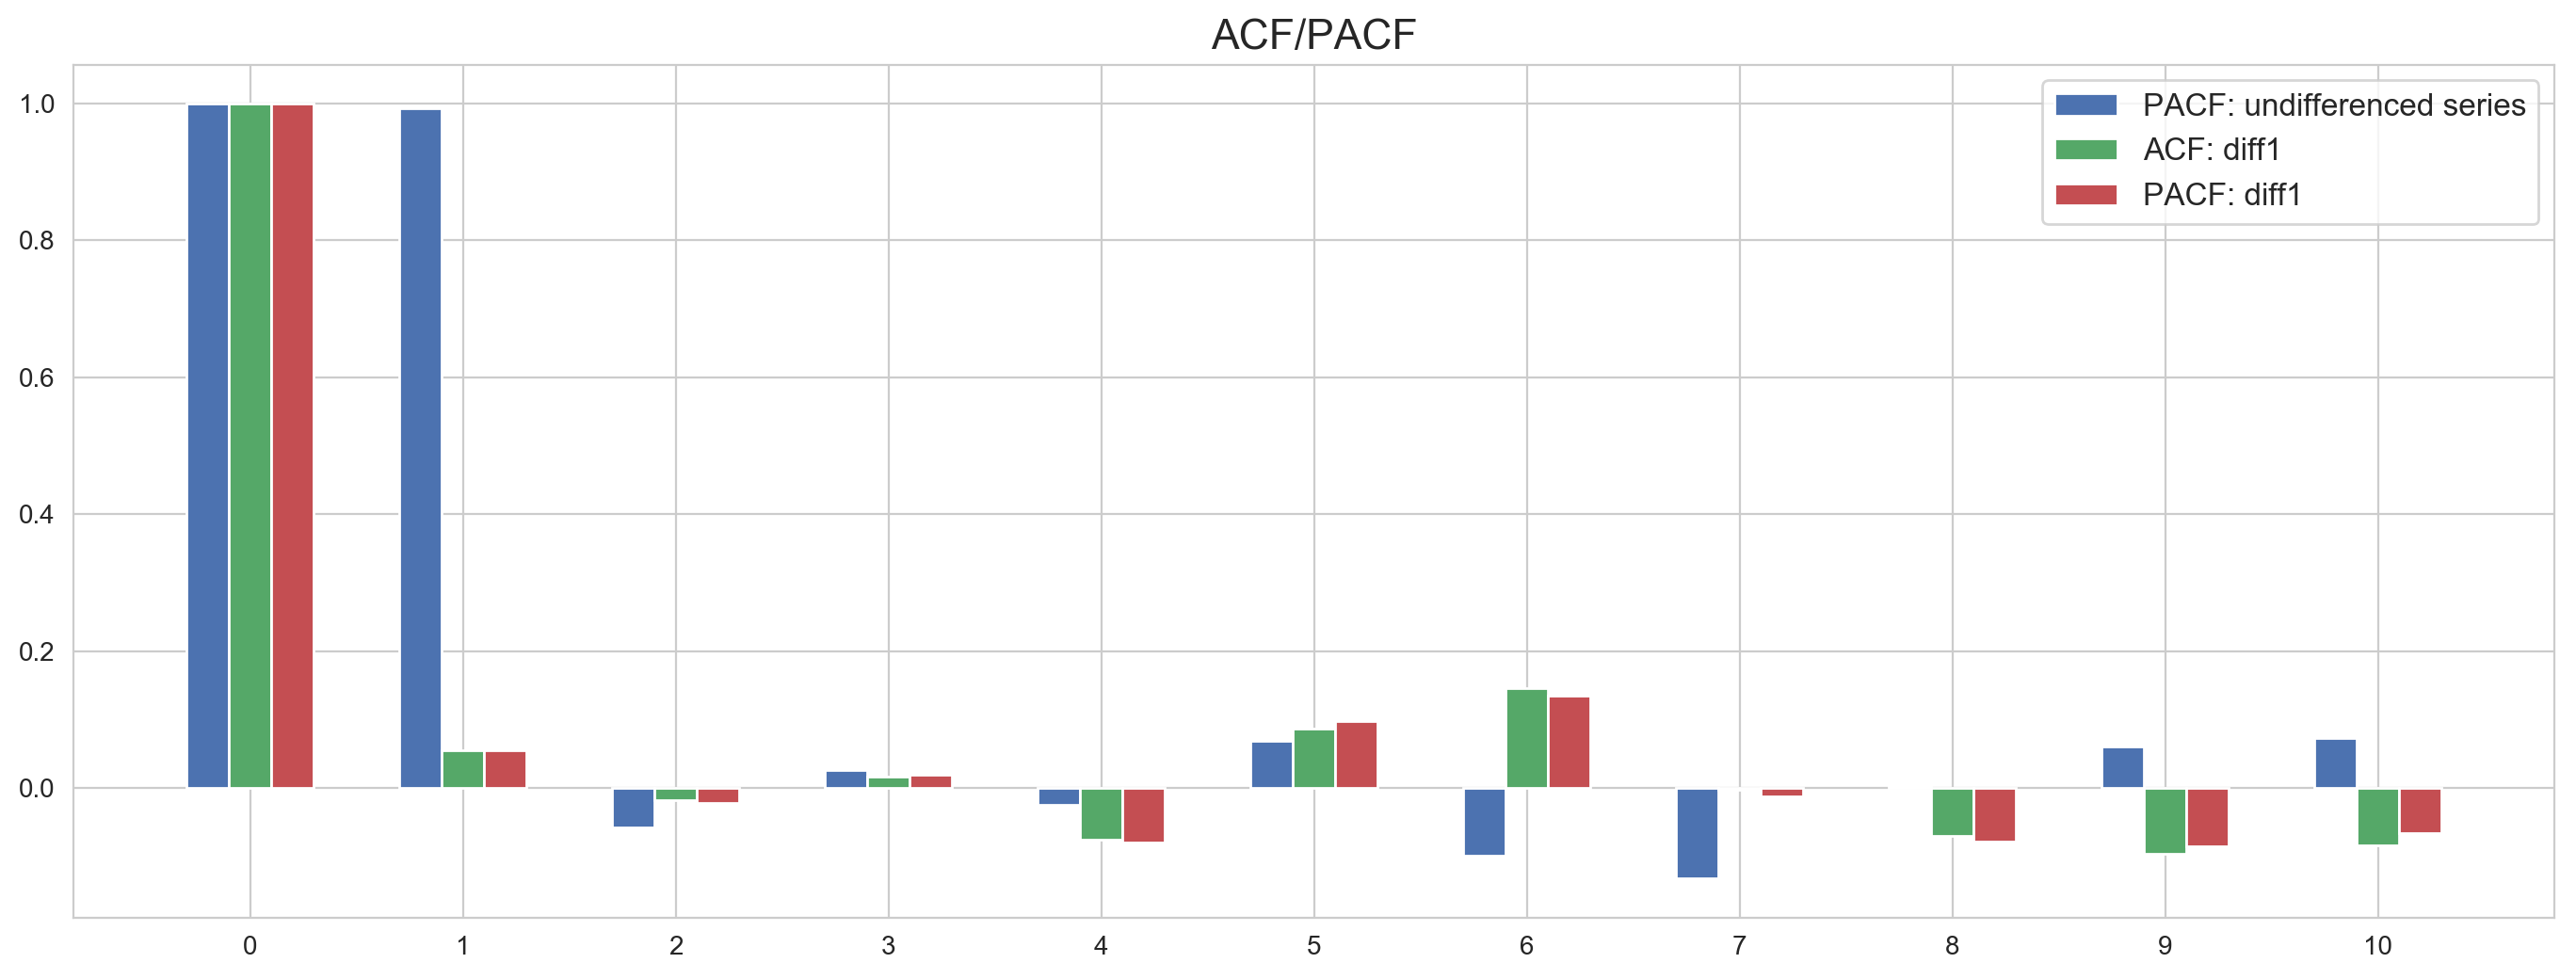

In [147]:
pacf_ts = pacf(ts.eth_close, nlags=10)
acf_diff1 = acf(ts.diff1.dropna(), nlags=10)
pacf_diff1 = pacf(ts.diff1.dropna(), nlags=10)

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.bar(
    [n-.2 for n in range(len(pacf_ts))],
    pacf_ts,
    label="PACF: undifferenced series",
    width=.2,
    color=colors[0],
    align='center'
)
ax.bar(
    [n for n in range(len(acf_diff1))],
    acf_diff1,
    label="ACF: diff1",
    width=.2,
    color=colors[2],
    align='center'
)
ax.bar(
    [n+.2 for n in range(len(acf_diff1))],
    pacf_diff1,
    label="PACF: diff1",
    width=.2,
    color=colors[3],
    align='center'
)
ax.legend(prop={'size':ax_fontsize})
ax.set_title("ACF/PACF", size=title_fontsize)
ax.set(xticks= [n for n in range(len(acf_diff1))])

plt.show()

**Interpretation**:
- ACF: perhaps a small MA component
- PACF perhaps a small AR component

### 3.1.2 ARIMA Modeling & Forecasting
- Build the following:
    - ARIMA(0,1,0): d=1, no AR/MA component
    - ARIMA(1,1,0): ar=1, d=1, no MA component
    - ARIMA(0,1,1): d=1, ma=1, no AR component
- Evaluation:
    - AIC/BIC
    - RMSE

In [148]:
def arima_forecast(endog, order, window, n_steps=1, exog=None):
    start = 0
    stop = window
    aic = []
    preds = []
    
    for n in range(len(endog) - window):
        if exog is None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                order=order
            ).fit()
            # make and store forecasts
            yhat = model.forecast(steps=n_steps)
        
        if exog is not None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                exog=exog[start:stop],
                order=order
            ).fit(trend='nc')
            # make and store forecasts
            yhat = model.forecast(
                steps=n_steps,
                exog=exog[stop:stop+1]
            )
            
        # store results and step forward
        aic.append(model.aic)
        preds.append(yhat[0][0])
        start += 1
        stop += 1
   
    results = np.array([preds, aic])
    return results

def rmse(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed[-len(predicted):], predicted))
    return rmse

In [149]:
# set required variables
endog = ts.eth_close

# instantiate, train, & forecast
d1_fc = arima_forecast(
    endog=endog,
    order=(0,1,0),
    window=window
)
ar1_fc = arima_forecast(
    endog=endog,
    order=(1,1,0),
    window=window
)
ma1_fc = arima_forecast(
    endog=endog,
    order=(0,1,1),
    window=window
)

# evaluate results
forecasts = {
    'd1_fc': d1_fc,
    'ar1_fc': ar1_fc,
    'ma1_fc': ma1_fc
}

arima_preds_rmse = {}
for name, model in forecasts.items():
    # calculate error
    rmse_pred = rmse(ts.eth_close[window:], model[0])
    arima_preds_rmse.update({name:rmse_pred})

arima_summary_df = pd.DataFrame.from_dict(arima_preds_rmse, orient='index', columns=['rmse'])
print("ARIMA RMSE Results")
display(arima_summary_df)

# get best model    
best_model = min(arima_preds_rmse, key=arima_preds_rmse.get)
print("best model: {}\nrmse: {:.6f}".format(best_model, arima_preds_rmse[best_model]))

ARIMA RMSE Results


,rmse
d1_fc,33.406686
ar1_fc,34.006910
ma1_fc,34.038077


best model: d1_fc
rmse: 33.406686


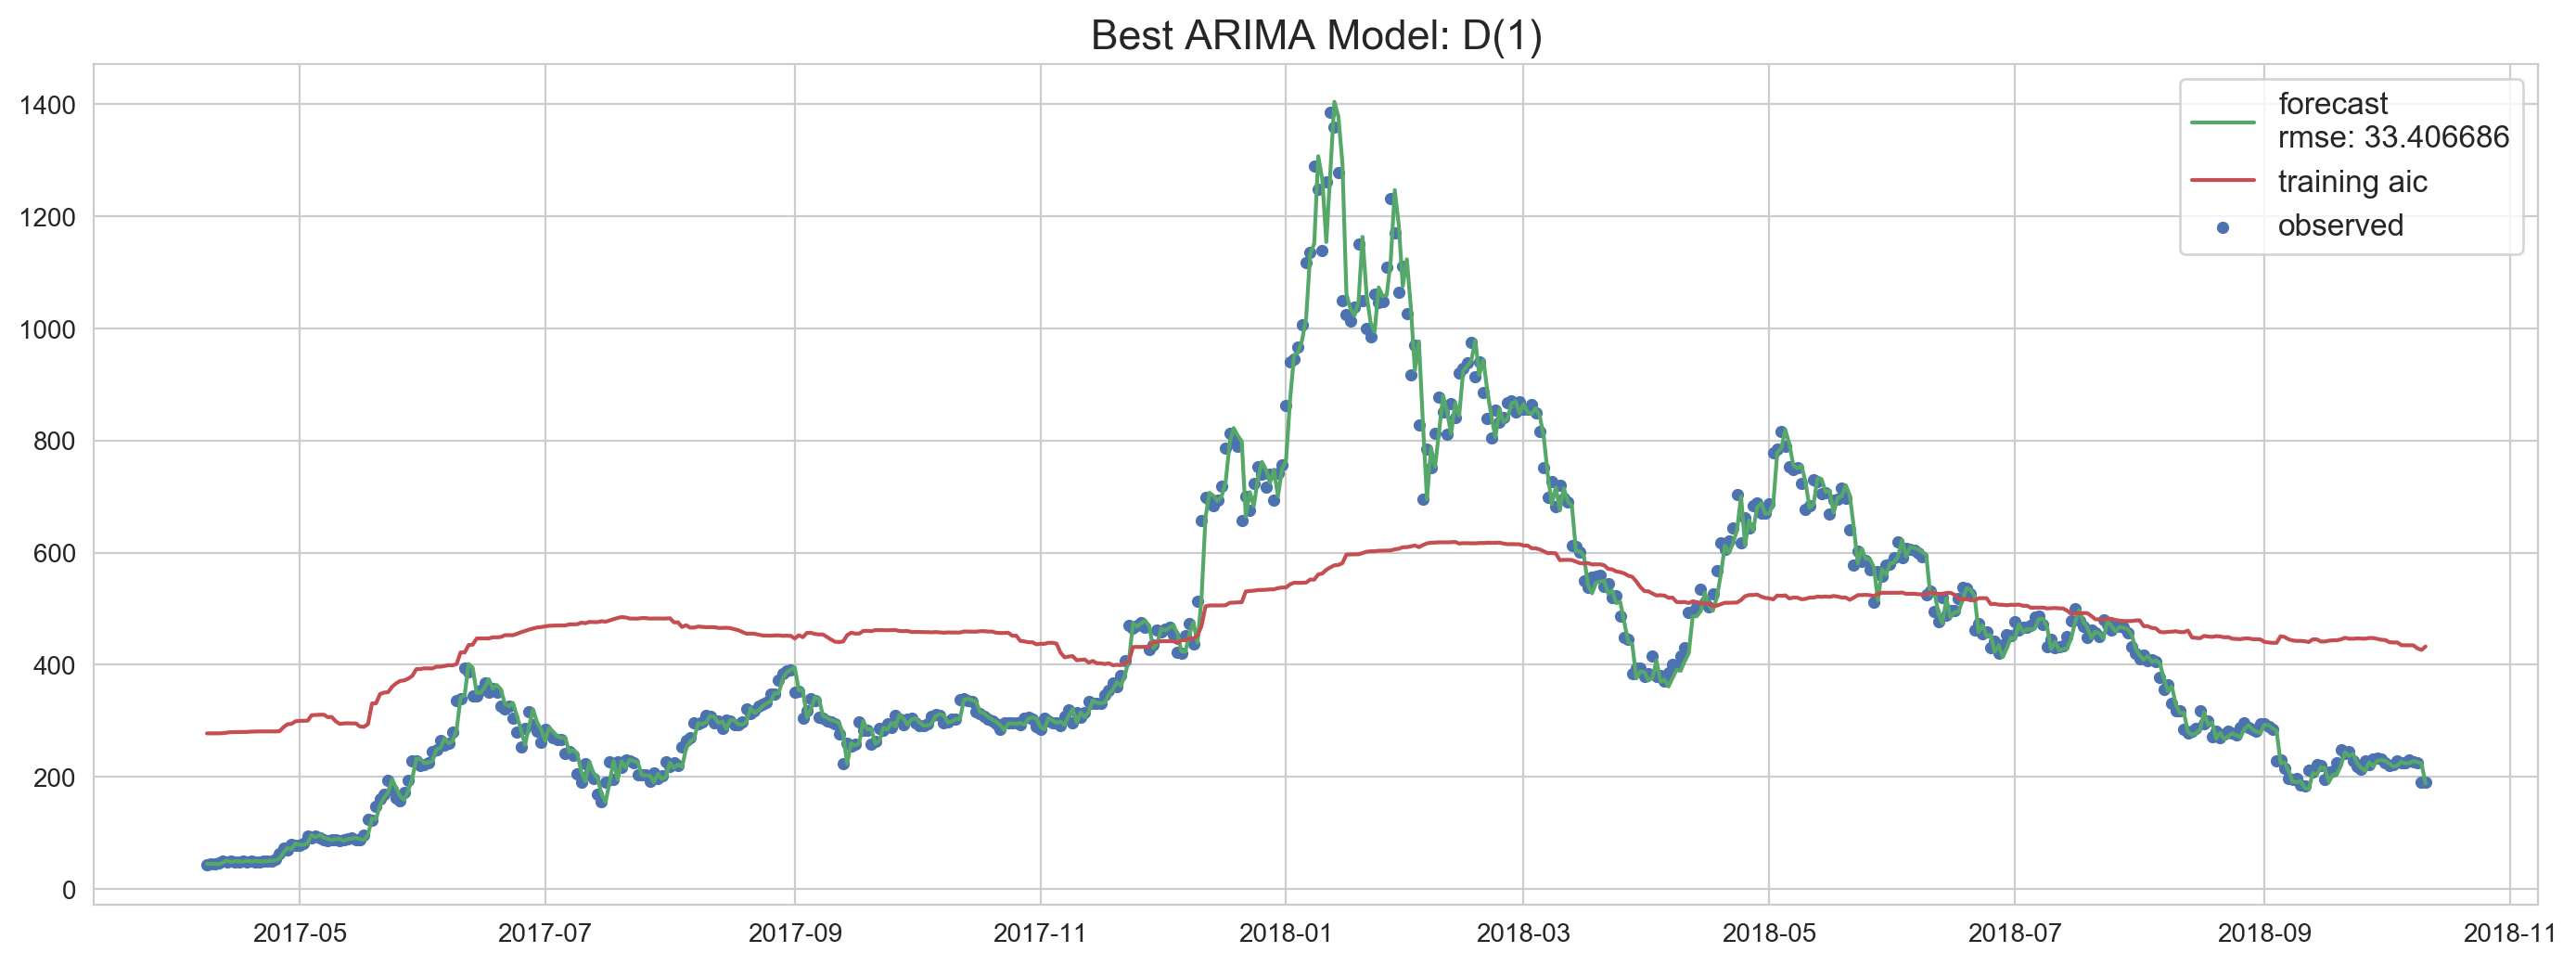

In [150]:
# plot results
x_dates = ts.eth_close.index[window:]
observed = ts.eth_close[window:]

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.set_title("Best ARIMA Model: D(1)", size=title_fontsize)
# best arima
ax.plot(
    x_dates,
    forecasts[best_model][0],
    label="forecast\nrmse: {:.6f}".format(arima_preds_rmse[best_model]),
    c=colors[2]
)
# plot observed values
ax.scatter(
    x_dates,
    observed,
    label = "observed",
    c=colors[0],
    s=14
)
# plot train aic for fun
ax.plot(
    x_dates,
    forecasts[best_model][1],
    label="training aic",
    c=colors[3]
)
#plt.setp(ax.lines, linewidth=1.5)
plt.legend(prop={'size':ax_fontsize})
plt.show()

### ARIMA Results:
- Best RMSE: diff1 models
- Model performance when using AR/MA component suffers
- Structural Breaks:
    - Including changepoints slightly increases error
    - Either:
        - Model is capturing this on it's own
        - Calculated change points are not very accurate

<a id='ann'></a>
## 3.2 Artifical Neural Networks

In [151]:
def shift_data(df, n_shifts):
    # copy df, shift cols in a new df and concat them
    df_shifted = df.copy()
    for i in range(n_shifts):
        df = pd.concat([df, df_shifted.shift(i+1)], axis=1)
        df.dropna(axis=0, inplace=True)
    
    # rename columns    
    cols = list(df.columns)[1:]
    for i, col in enumerate(cols):
        cols[i] = 'shift_{}'.format(i+1)
    cols = [df.columns[0]] + cols
    df.columns = cols
    return df

def shape_data(data):
    data = np.array(data).reshape(data.shape[0], data.shape[1], 1)
    return data

def build_lstm(X, loss, optimizer, lr, units=1, activation='tanh', use_bias=True):
    model = Sequential()
    model.add(LSTM(units=units,
                   activation=activation,
                   use_bias=use_bias,
                   input_shape=(X.shape[1], X.shape[2])))
    #model.add(Dropout(0.05))
    #model.add(LSTM(units=units,
    #               activation=activation,
    #               use_bias=use_bias,
    #               input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))

    model.compile(
        loss=loss,
        metrics=['mse'],
        optimizer=optimizer
    )
    return model

def lstm_forecast(model, X, y, window, epochs, verbose=0, callbacks=None):
    start = 0
    stop = window
    preds = []
    observed = ts.eth_close.values[-(len(X)-window):]
    
    for i in range(len(y) - window):
                
        # set train data to window sized chunk
        X_train, y_train = X[start:stop], y[start:stop]
        # set test data to one step after train data
        X_test, y_test = X[stop:stop + 1], y[stop:stop + 1]
        
        # fit model
        start_time = time.time()
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_split=0.1
        )
        # make & store prediction, step foreward
        yhat = model.predict(X_test)
        yhat = scaler.inverse_transform(np.array(yhat[0][0]).reshape(-1,1))
        preds.append(yhat)
        
        # monitor function without model verbosity
        if start != 0 and start % 100  == 0:
            print("iteration {} predicted: {} (observed: {}) in {:.2f} seconds".format(
                start, yhat, observed[start], (time.time()-start_time)))
            
        start += 1
        stop += 1
    return preds

def lstm_rmse(preds):
    rmse = np.sqrt(mean_squared_error(ts.eth_close.values[-len(preds):],
                                      np.array(preds).reshape(len(preds),)))
    return rmse

In [152]:
# set series to manipulate for ANNs
ts_nn = pd.DataFrame(ts.eth_close.copy())
ts_nn.rename(columns={'eth_close':'unshifted'}, inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts_nn.values)
ts_nn = pd.DataFrame(ts_scaled).set_index(ts_nn.index.values)
ts_nn.columns = ['unshifted']
print("original df:\nshape: {}".format(ts_nn.shape))
#display(ts_nn.head(3), ts_nn.tail(3))

# shift dataset
ts_nn = shift_data(ts_nn, n_shifts=1)
print("shifted df:\nshape: {}".format(ts_nn.shape))
#display(ts_nn.head(3), ts_nn.tail(3))

# set data/target
X = ts_nn.loc[:, ~ts_nn.columns.isin(['unshifted'])]
y = ts_nn.unshifted
#print(X.shape, y.shape)

# reshape
X = shape_data(X)
print("Final shapes X, y: {}, {}".format(X.shape, y.shape))

original df:
shape: (606, 1)
shifted df:
shape: (605, 2)
Final shapes X, y: (605, 1, 1), (605,)


## LSTM Models
- GridSearchCV isn't cooperating, either I don't have it set up correctly or it's just incredibly slow
- Run 3 optimizers with default learning rates
- If time, tune LR and units

In [153]:
# set dicts to store results
lstm_results_dict = {}
lstm_rmse_dict = {}

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=25,
    verbose=0)

optimizers = {'Adam': 0.001, 'RMSprop': 0.001, 'Adamax': 0.002, 'Nadam': 0.002, 'SGD': 0.01}

for optimizer, lr in optimizers.items():
    print(optimizer, lr)
    lstm = build_lstm(
        X=X,
        units=16,
        activation='tanh',
        loss='mean_squared_error',
        optimizer=optimizer,
        lr=lr
    )
    # train & forecast
    start_time = time.time()
    lstm_ = lstm_forecast(
        model=lstm,
        window=window,
        X=X,
        y=y,
        epochs=500,
        callbacks=[early_stopping]
    )
    # print and store results
    print("runtime: {:.2f} seconds".format(time.time() - start_time))
    print("rmse: {}\n".format(lstm_rmse(lstm_)))
    
    lstm_results_dict.update({"{}lr{}".format(optimizer, lr): lstm_})
    lstm_rmse_dict.update({"{}lr{}".format(optimizer, lr): lstm_rmse(lstm_)})

Adam 0.001
iteration 100 predicted: [[232.02087]] (observed: 194.41) in 0.19 seconds
iteration 200 predicted: [[297.93985]] (observed: 296.36) in 0.20 seconds
iteration 300 predicted: [[995.4906]] (observed: 827.59) in 0.21 seconds
iteration 400 predicted: [[731.7866]] (observed: 705.64) in 0.58 seconds
iteration 500 predicted: [[264.63232]] (observed: 275.83) in 0.57 seconds
runtime: 234.87 seconds
rmse: 37.85654040889463

RMSprop 0.001
iteration 100 predicted: [[233.52531]] (observed: 194.41) in 0.47 seconds
iteration 200 predicted: [[298.26755]] (observed: 296.36) in 1.10 seconds
iteration 300 predicted: [[990.4236]] (observed: 827.59) in 0.27 seconds
iteration 400 predicted: [[727.892]] (observed: 705.64) in 0.25 seconds
iteration 500 predicted: [[260.32452]] (observed: 275.83) in 0.64 seconds
runtime: 225.16 seconds
rmse: 37.00943606742196

Adamax 0.002
iteration 100 predicted: [[231.95862]] (observed: 194.41) in 0.41 seconds
iteration 200 predicted: [[294.67883]] (observed: 296.3

In [154]:
print(min(lstm_rmse_dict, key=lstm_rmse_dict.get))

Adamaxlr0.002


### Tune Learning Rate

In [155]:
optimizer = 'Adamax'
learning_rates = [0.001, 0.0015, 0.0025, 0.003, 0.0035]

for lr in learning_rates:
    print("{} {}".format(optimizer, lr))
    lstm = build_lstm(
        X=X,
        units=1,
        activation='tanh',
        loss='mean_squared_error',
        optimizer=optimizer,
        lr=lr
    )
    # train & forecast
    start_time = time.time()
    lstm_fc = lstm_forecast(
        model=lstm,
        window=window,
        X=X,
        y=y,
        epochs=500,
        callbacks=[early_stopping]
    )
    # print and store results
    print("runtime: {:.2f} seconds".format(time.time() - start_time))
    print("rmse: {}".format(lstm_rmse(lstm_fc)))
    
    lstm_results_dict.update({"{}lr{}".format(optimizer, lr): lstm_fc})
    lstm_rmse_dict.update({"{}lr{}".format(optimizer, lr): lstm_rmse(lstm_fc)})

Adamax 0.001
iteration 100 predicted: [[231.27525]] (observed: 194.41) in 0.20 seconds
iteration 200 predicted: [[296.2036]] (observed: 296.36) in 0.40 seconds
iteration 300 predicted: [[990.432]] (observed: 827.59) in 0.17 seconds
iteration 400 predicted: [[732.58813]] (observed: 705.64) in 0.38 seconds
iteration 500 predicted: [[268.17603]] (observed: 275.83) in 0.19 seconds
runtime: 224.51 seconds
rmse: 37.20813706629489
Adamax 0.0015
iteration 100 predicted: [[231.85033]] (observed: 194.41) in 0.30 seconds
iteration 200 predicted: [[294.89325]] (observed: 296.36) in 0.47 seconds
iteration 300 predicted: [[1001.94226]] (observed: 827.59) in 0.26 seconds
iteration 400 predicted: [[731.9353]] (observed: 705.64) in 0.51 seconds
iteration 500 predicted: [[268.84277]] (observed: 275.83) in 0.33 seconds
runtime: 226.24 seconds
rmse: 43.315237697114085
Adamax 0.0025
iteration 100 predicted: [[231.35432]] (observed: 194.41) in 0.21 seconds
iteration 200 predicted: [[295.5234]] (observed: 29

In [156]:
print(min(lstm_rmse_dict, key=lstm_rmse_dict.get))

Adamaxlr0.002


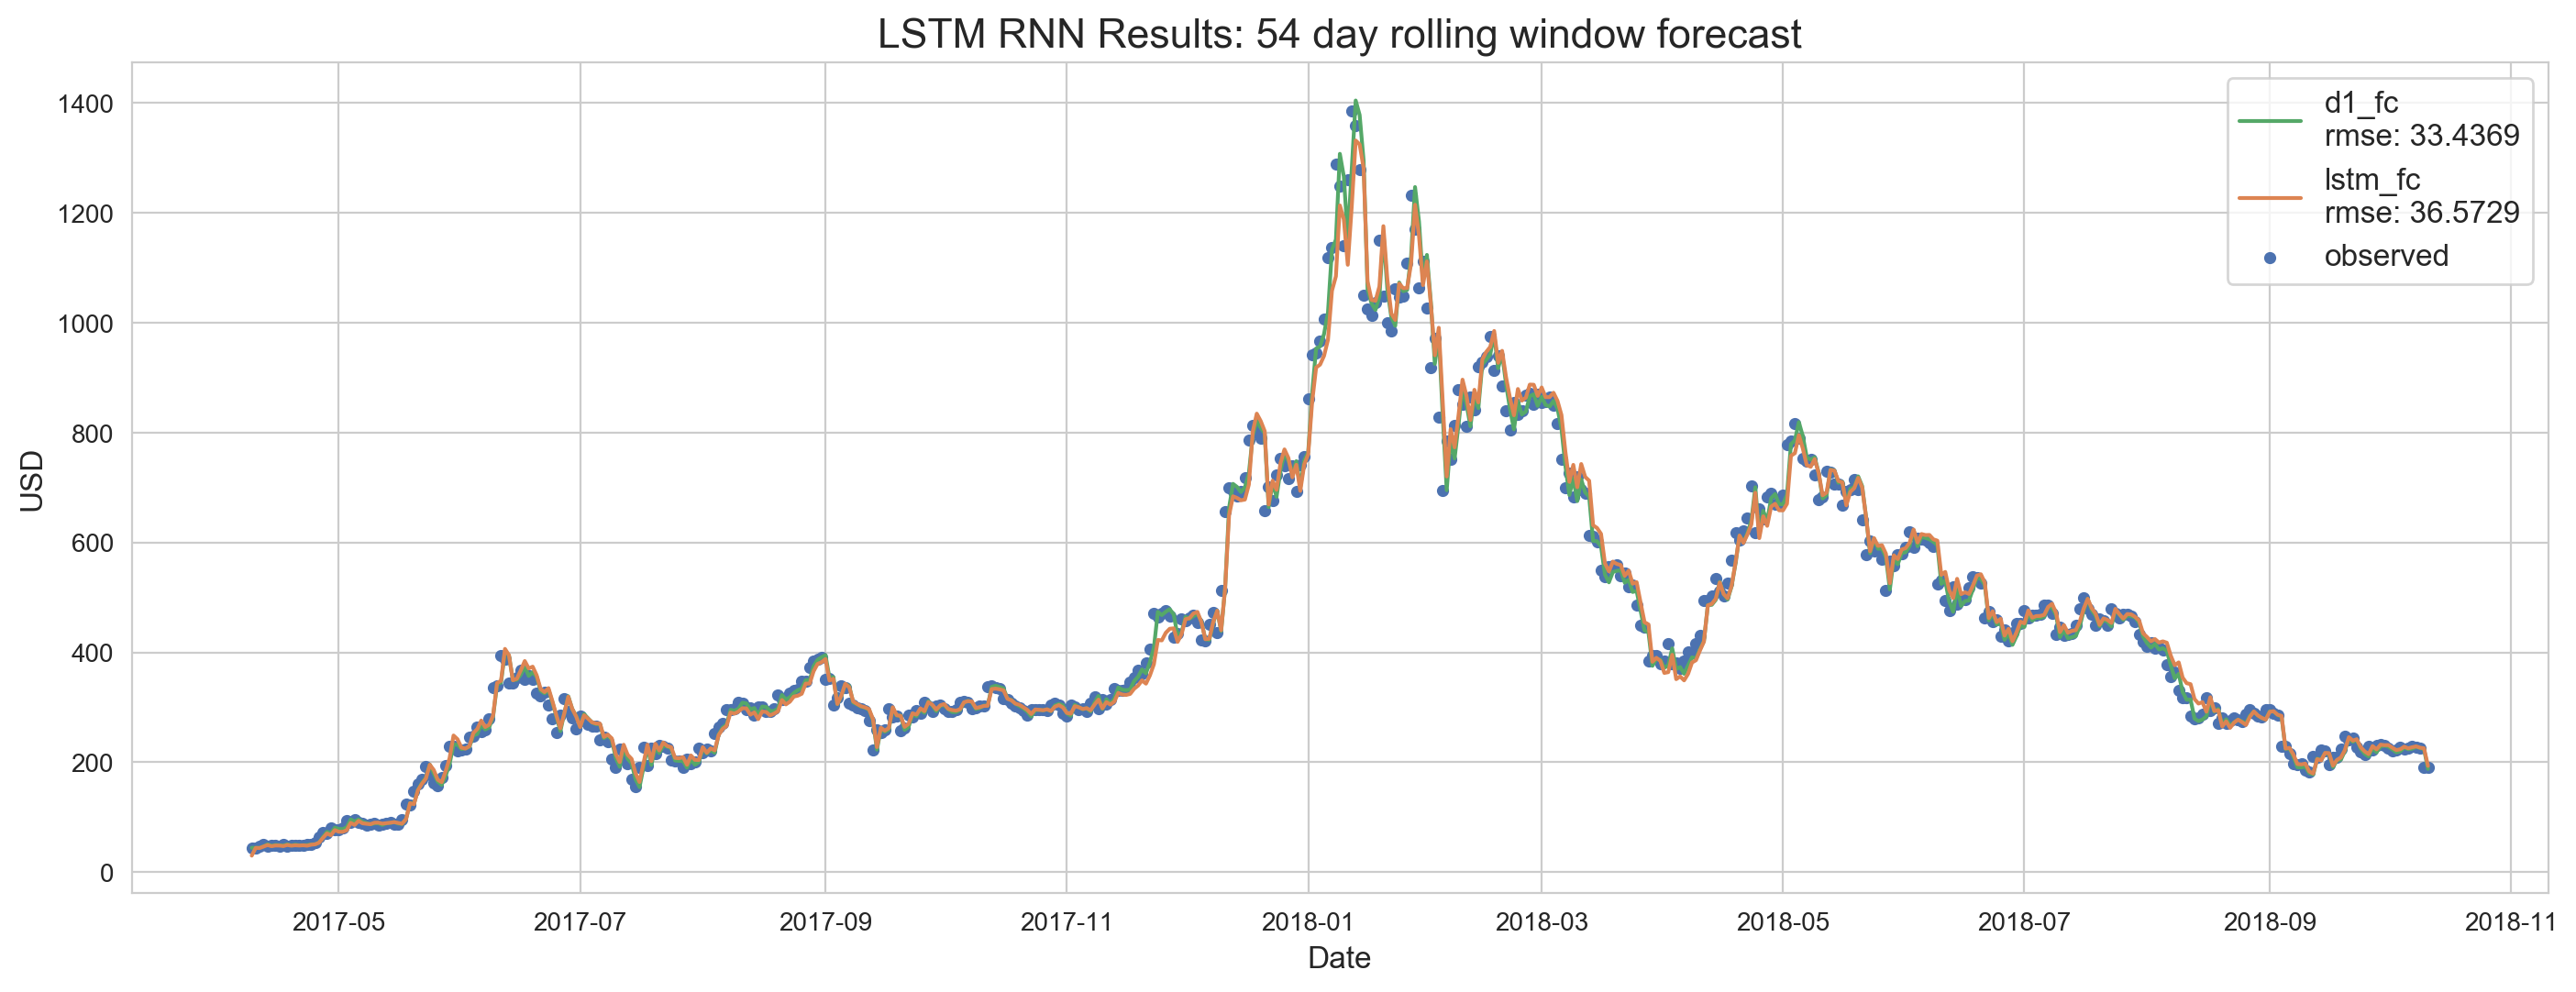

In [157]:
# compare best LSTM to same set of forecasts from ARIMA
best_lstm = lstm_results_dict['Adamaxlr0.002']

# exclude arima predicted values that aren't predicted by lstm
d1_fc_rmse = np.sqrt(mean_squared_error(
    ts.eth_close.values[-len(best_lstm):], d1_fc[0][-len(best_lstm):]))

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm):].index,
    ts.eth_close.values[-len(best_lstm):],
    label="observed",
    c=colors[0],
    s=14
)
# arima forecast
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    d1_fc[0][-len(best_lstm):],
    label="d1_fc\nrmse: {:.4f}".format(d1_fc_rmse),
    c=colors[2]
)
# lstm forecast
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    np.array(best_lstm).reshape(len(best_lstm),),
    label="lstm_fc\nrmse: {:.4f}".format(lstm_rmse(best_lstm)),
    c=colors[1]
)
ax.set_title("LSTM RNN Results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

# 4. Time Series with Exogenous Variables

The following exogenous data was collected to potentially include as features for price forecasting
1. Ethereum trading data:
    - **Open, High, Low, Close (OHLC)**
    - **VolumeFrom**: trade volume in terms of ETH
    - **VolumeTo**: trade volume in terms of USD
2. Other Cryptocurrency prices:
    - **BTC (Bitcoin)**: the first decentralized cryptocurrency
    - **XRP (Ripple)**: real-time gross settlement system with the goal to enable "secure, instantly and nearly free global financial transactions of any size with no chargebacks."
    - **EOS (EOS.IO)**: smart contract platform and decentralized operating system intended for the deployment of industrial-scale decentralized applications
    - **LTC (Litecoin)**: technically similar to BTC, except provides faster transaction confirmations (2.5 minutes on average) and uses a memory-hard, scrypt-based mining proof-of-work algorithm to target the regular computers and GPUs most people already have
    - **XLM (Stellar)**: open-source, decentralized protocol for digital currency to fiat currency transfers which allows cross-border transactions between any pair of currencies
    - **XMR (Monero)**: in contrast to most coins, public ledger is obfuscated which allows users to broadcast or send transactions, but no outside observer can tell the source, amount or destination
3. Other Economic Indicators:
    - **VIXCLS (CBOE Volatility Index)**: measure of market expectation of near term volatility conveyed by stock index option prices
    - **TWEXB (Trade Weighted US Dollar Index: Broad)**: weighted average of the foreign exchange value of the U.S. dollar against the currencies of a broad group of major U.S. trading partners
    - **EFFR (Effective Federal Funds Rate)**: volume-weighted median of overnight federal funds transactions

In [158]:
# eth related
exog_eth = raw[
    ['eth_open', 'eth_high', 'eth_low', 'eth_volumefrom', 'eth_volumeto']
][break_points[0]:].copy()
display(exog_eth.head(1))

# missingness check
for col in exog_eth.columns:
    n_missing = exog_eth['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_eth)*100)))

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto
2017-02-13,11.39,14.05,11.32,694347.97,8633943.17



eth_open
missing: 0, 0.00% of total

eth_high
missing: 0, 0.00% of total

eth_low
missing: 0, 0.00% of total

eth_volumefrom
missing: 0, 0.00% of total

eth_volumeto
missing: 0, 0.00% of total


In [159]:
# other crypto prices
exog_coins = raw[
    ['btc_close', 'xrp_close', 'eos_close', 'ltc_close', 'xlm_close', 'xmr_close']
][break_points[0]:].copy()
display(exog_coins.head(1))

# missingness check
for col in exog_coins.columns:
    n_missing = exog_coins['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_coins)*100)))

# significant portions of eos & xlm missing, drop features
exog_coins.drop(['eos_close', 'xlm_close'], axis=1, inplace=True)
display(exog_coins.head(1))

,btc_close,xrp_close,eos_close,ltc_close,xlm_close,xmr_close
2017-02-13,1008.34,0.00622,NaN,3.8,0.001892,13.02



btc_close
missing: 0, 0.00% of total

xrp_close
missing: 0, 0.00% of total

eos_close
missing: 135, 22.28% of total

ltc_close
missing: 0, 0.00% of total

xlm_close
missing: 0, 0.00% of total

xmr_close
missing: 0, 0.00% of total


,btc_close,xrp_close,ltc_close,xmr_close
2017-02-13,1008.34,0.00622,3.8,13.02


In [160]:
# other index related
exog_idx = raw[
    ['vixcls', 'twexb', 'effr']
][break_points[0]:].copy()
display(exog_idx.head(1))

# missingness check
for col in exog_idx.columns:
    n_missing = exog_idx['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_idx)*100)))

,vixcls,twexb,effr
2017-02-13,11.07,125.493,0.66



vixcls
missing: 0, 0.00% of total

twexb
missing: 0, 0.00% of total

effr
missing: 0, 0.00% of total


<a id='granger_causality'></a>
## Granger Causality
A statistical hypothesis test for determining whether one time series is useful in forecasting another.
- Tests the ability to predict the future values of a time series using prior values of another time series
- **Predictive (or probabilistic)  causality**: A time series $X$ is said to Granger-cause $Y$ if it can be shown, usually through a series of t-tests and F-tests on lagged values of $X$ (and with lagged values of $Y$ also included), that those $X$ values provide statistically significant information about future values of $Y$

In [161]:
def granger_causality(var1, var2, diff=1):
    
    if diff is not None:
        df = pd.concat([var1, var2], axis=1)
        results = grangercausalitytests(
            df[['{}'.format(df.columns[0]), '{}'.format(df.columns[1])]],
            maxlag=1, verbose=False)[1][0]
        return results

In [162]:
# put all in one df
exog_all = pd.concat([exog_eth, exog_coins, exog_idx], axis=1)
exog_all.head(1)

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto,btc_close,xrp_close,ltc_close,xmr_close,vixcls,twexb,effr
2017-02-13,11.39,14.05,11.32,694347.97,8633943.17,1008.34,0.00622,3.8,13.02,11.07,125.493,0.66


In [163]:
# granger causality tests
gc_all = {}
gc_sig = []

for col in exog_all.columns:
    results = granger_causality(ts.eth_close, exog_all['{}'.format(col)])
    gc_all.update({col:results})
    for key, value in results.items():
        if value[1] <= 0.05:
            if col not in gc_sig:
                gc_sig.append(col)
                
for var in gc_sig:
    print("\n{}".format(var))
    print(gc_all['{}'.format(var)])


eth_low
{'ssr_ftest': (8.074701531416123, 0.004640747058873819, 602.0, 1), 'ssr_chi2test': (8.114940907818527, 0.004390190383943897, 1), 'lrtest': (8.06099936202645, 0.004522822990955286, 1), 'params_ftest': (8.074701531415919, 0.004640747058874594, 602.0, 1.0)}

eth_volumefrom
{'ssr_ftest': (4.798422088361457, 0.028868566532146988, 602.0, 1), 'ssr_chi2test': (4.822334490795152, 0.028093271759724894, 1), 'lrtest': (4.803217077164845, 0.028406645758713257, 1), 'params_ftest': (4.798422088358041, 0.028868566532203706, 602.0, 1.0)}

eth_volumeto
{'ssr_ftest': (9.508736973808961, 0.002138604612559368, 602.0, 1), 'ssr_chi2test': (9.556122706236579, 0.001992835902772422, 1), 'lrtest': (9.481437481661487, 0.0020756127052509754, 1), 'params_ftest': (9.50873697355089, 0.0021386046128553915, 602.0, 1.0)}

btc_close
{'ssr_ftest': (13.80370962202343, 0.00022182810101274318, 602.0, 1), 'ssr_chi2test': (13.872498872631521, 0.00019564038466878144, 1), 'lrtest': (13.715842610949949, 0.000212653066115

In [164]:
gc_reverse_all = {}
gc_reverse_sig = []

for col in exog_all.columns:
    results = granger_causality(exog_all['{}'.format(col)], ts.eth_close)
    gc_reverse_all.update({col:results})
    for key, value in results.items():
        if value[1] <= 0.05:
            if col not in gc_reverse_sig:
                gc_reverse_sig.append(col)
                
for var in gc_reverse_sig:
    print("\n{}".format(var))
    print(gc_reverse_all['{}'.format(var)])


eth_open
{'ssr_ftest': (109134565.10895821, 0.0, 602.0, 1), 'ssr_chi2test': (109678425.06797294, 0.0, 1), 'lrtest': (7325.243376574436, 0.0, 1), 'params_ftest': (109134565.10895814, 0.0, 602.0, 1.0)}

eth_high
{'ssr_ftest': (423.4470580730527, 1.1930532023355336e-71, 602.0, 1), 'ssr_chi2test': (425.557259359131, 1.5061274321822667e-94, 1), 'lrtest': (322.2390357631866, 4.711899330856419e-72, 1), 'params_ftest': (423.4470580730654, 1.1930532023310577e-71, 602.0, 1.0)}

eth_low
{'ssr_ftest': (283.9237657958852, 1.7774163199543258e-52, 602.0, 1), 'ssr_chi2test': (285.33866828324005, 5.155208925738517e-64, 1), 'lrtest': (233.7559423771154, 9.04195526883448e-53, 1), 'params_ftest': (283.923765795878, 1.7774163199585947e-52, 602.0, 1.0)}

eth_volumeto
{'ssr_ftest': (78.7830787813796, 7.903648927681595e-18, 602.0, 1), 'ssr_chi2test': (79.17568548627021, 5.682514756914155e-19, 1), 'lrtest': (74.40669742618047, 6.357296241886245e-18, 1), 'params_ftest': (78.78307878137954, 7.903648927681595e-1

In [165]:
for var in gc_sig:
    if var not in gc_reverse_sig:
        print(var)

eth_volumefrom
xrp_close
ltc_close
xmr_close


In [166]:
exog_gc = exog_all.loc[:, exog_all.columns.isin([
    'eth_volumefrom',
    'xrp_close',
    'ltc_close',
    'xmr_close']
)].copy()

# 5. Modeling & Forecasting with Exogenous Variables

### ARIMA

In [167]:
# set endog
endog = ts.eth_close[1:]

X_eth_volumefrom = exog_eth.eth_volumefrom.copy().shift(1).dropna()
X_xrp_close = exog_coins.xrp_close.copy().shift(1).dropna()
X_ltc_close = exog_coins.ltc_close.copy().shift(1).dropna()
X_xmr_close = exog_coins.xmr_close.copy().shift(1).dropna()
X_all_gc = exog_all.loc[:, exog_all.columns.isin([
    'eth_volumefrom',
    'xrp_close',
    'ltc_close',
    'xmr_close']
)].copy().shift(1).dropna()

In [168]:
print("\nd1_fc rmse: {}".format(rmse(endog, d1_fc[0])))

order = (0,1,0)
exog_vars = {
    'eth_volumefrom': X_eth_volumefrom,
    'xrp_close': X_xrp_close,
    'ltc_close': X_ltc_close,
    'xmr_close': X_xmr_close,
    'all_gc': X_all_gc
}

exog_arima_results = {}
exog_arima_rmse = {}

for key, value in exog_vars.items():
    results = arima_forecast(
        endog=endog,
        exog=value,
        order=order,
        window=window
    )
    print("\nd1x {} rmse: {}".format(key, rmse(endog, results[0])))
    exog_arima_results.update({key: results})
    exog_arima_rmse.update({key: rmse(endog, results[0])})


d1_fc rmse: 33.406685757981776

d1x eth_volumefrom rmse: 33.249430318234424

d1x xrp_close rmse: 33.62587605799207

d1x ltc_close rmse: 33.44838611354702

d1x xmr_close rmse: 33.514031333581215

d1x all_gc rmse: 35.32763952774076


## LSTM RNN
LSTM models with exogenous variables:
1. [eth_volumefrom](#eth_volumefrom)
2. [xrp_close](#xrp_close)
3. [ltc_close](#ltc_close)
4. [xmr_close](#xmr_close)
5. [all_gc](#all_gc)

In [169]:
X_eth_volumefrom = exog_eth.eth_volumefrom.copy()
X_eth_volumefrom = pd.concat([X_eth_volumefrom, ts.eth_close], axis=1)

X_eth = X_eth_volumefrom.shift(1).copy().dropna()
y = X_eth_volumefrom.eth_close[1:]

scaler = MinMaxScaler(feature_range=(0,1))
X_eth_scaled = scaler.fit_transform(X_eth.values)
y_eth = scaler.fit_transform(np.array(y).reshape(-1,1))

X_eth = shape_data(X_eth_scaled)
print(X_eth.shape, y_eth.shape)

(605, 2, 1) (605, 1)


In [170]:
X_xrp_close = exog_coins.xrp_close.copy()
X_xrp_close = pd.concat([X_xrp_close, ts.eth_close], axis=1)

X_xrp = X_xrp_close.shift(1).copy().dropna()
y = X_xrp_close.eth_close[1:]

scaler = MinMaxScaler(feature_range=(0,1))
X_xrp_scaled = scaler.fit_transform(X_xrp.values)
y_xrp = scaler.fit_transform(np.array(y).reshape(-1,1))

X_xrp = shape_data(X_xrp_scaled)
print(X_xrp.shape, y_xrp.shape)

(605, 2, 1) (605, 1)


In [171]:
X_ltc_close = exog_coins.ltc_close.copy()
X_ltc_close = pd.concat([X_ltc_close, ts.eth_close], axis=1)

X_ltc = X_ltc_close.shift(1).copy().dropna()
y = X_ltc_close.eth_close[1:]

scaler = MinMaxScaler(feature_range=(0,1))
X_ltc_scaled = scaler.fit_transform(X_ltc.values)
y_ltc = scaler.fit_transform(np.array(y).reshape(-1,1))

X_ltc = shape_data(X_ltc_scaled)
print(X_ltc.shape, y_ltc.shape)

(605, 2, 1) (605, 1)


In [172]:
X_xmr_close = exog_coins.xmr_close.copy()
X_xmr_close = pd.concat([X_xmr_close, ts.eth_close], axis=1)

X_xmr = X_xmr_close.shift(1).copy().dropna()
y = X_xmr_close.eth_close[1:]

scaler = MinMaxScaler(feature_range=(0,1))
X_xmr_scaled = scaler.fit_transform(X_xmr.values)
y_xmr = scaler.fit_transform(np.array(y).reshape(-1,1))

X_xmr = shape_data(X_xmr_scaled)
print(X_xmr.shape, y_xmr.shape)

(605, 2, 1) (605, 1)


In [173]:
X_allgc = exog_all.loc[:, exog_all.columns.isin([
    'eth_volumefrom',
    'xrp_close',
    'ltc_close',
    'xmr_close']
)].copy()
X_allgc = pd.concat([X_allgc, ts.eth_close], axis=1)

X_gc = X_allgc.shift(1).copy().dropna()
y = X_allgc.eth_close[1:]

scaler = MinMaxScaler(feature_range=(0,1))
X_gc_scaled = scaler.fit_transform(X_gc.values)
y_gc = scaler.fit_transform(np.array(y).reshape(-1,1))

X_gc = shape_data(X_gc_scaled)
print(X_gc.shape, y_gc.shape)

(605, 5, 1) (605, 1)


In [174]:
# dicts to store results and rmse scores
lstm_exog_results = {}
lstm_exog_rmse = {}

# set vars for models
optimizer='Adamax'
lr = 0.002

In [175]:
exog_vars = {'eth': [X_eth, y_eth],
             'xrp': [X_xrp, y_xrp],
             'ltc': [X_ltc, y_ltc],
             'xmr': [X_xmr, y_xmr],
             'gc': [X_gc, y_gc]}

for key, value in exog_vars.items():
    print(key)
    lstm = build_lstm(
        X=value[0],
        units=8,
        activation='tanh',
        loss='mean_squared_error',
        optimizer=optimizer,
        lr=lr
    )
    # train & forecast
    start_time = time.time()
    lstm_ = lstm_forecast(
        model=lstm,
        window=window,
        X=value[0],
        y=value[1],
        epochs=500,
        callbacks=[early_stopping]
    )
    # print and store results
    print("runtime: {:.2f} seconds".format(time.time() - start_time))
    print("rmse: {}\n".format(lstm_rmse(lstm_)))
    
    lstm_results_dict.update({"{}lr{}".format(optimizer, key): lstm_})
    lstm_rmse_dict.update({"{}lr{}\n".format(optimizer, key): lstm_rmse(lstm_)})

eth
iteration 100 predicted: [[311.57474]] (observed: 194.41) in 0.23 seconds
iteration 200 predicted: [[297.9893]] (observed: 296.36) in 0.41 seconds
iteration 300 predicted: [[991.7459]] (observed: 827.59) in 0.24 seconds
iteration 400 predicted: [[726.01135]] (observed: 705.64) in 0.38 seconds
iteration 500 predicted: [[260.16183]] (observed: 275.83) in 0.42 seconds
runtime: 286.47 seconds
rmse: 40.136457591745724

xrp
iteration 100 predicted: [[230.69022]] (observed: 194.41) in 0.29 seconds
iteration 200 predicted: [[296.27438]] (observed: 296.36) in 0.48 seconds
iteration 300 predicted: [[968.38434]] (observed: 827.59) in 0.23 seconds
iteration 400 predicted: [[713.444]] (observed: 705.64) in 0.47 seconds
iteration 500 predicted: [[265.7137]] (observed: 275.83) in 0.24 seconds
runtime: 309.31 seconds
rmse: 36.170711101808045

ltc
iteration 100 predicted: [[226.11176]] (observed: 194.41) in 1.07 seconds
iteration 200 predicted: [[296.32553]] (observed: 296.36) in 0.25 seconds
itera

<a id='exog_summary'></a>
## Summary: Forecasting with Exogenous Variables

In [178]:
print(min(exog_arima_rmse, key=exog_arima_rmse.get))
print(min(lstm_rmse_dict, key=lstm_rmse_dict.get))

eth_volumefrom
Adamaxlrxrp



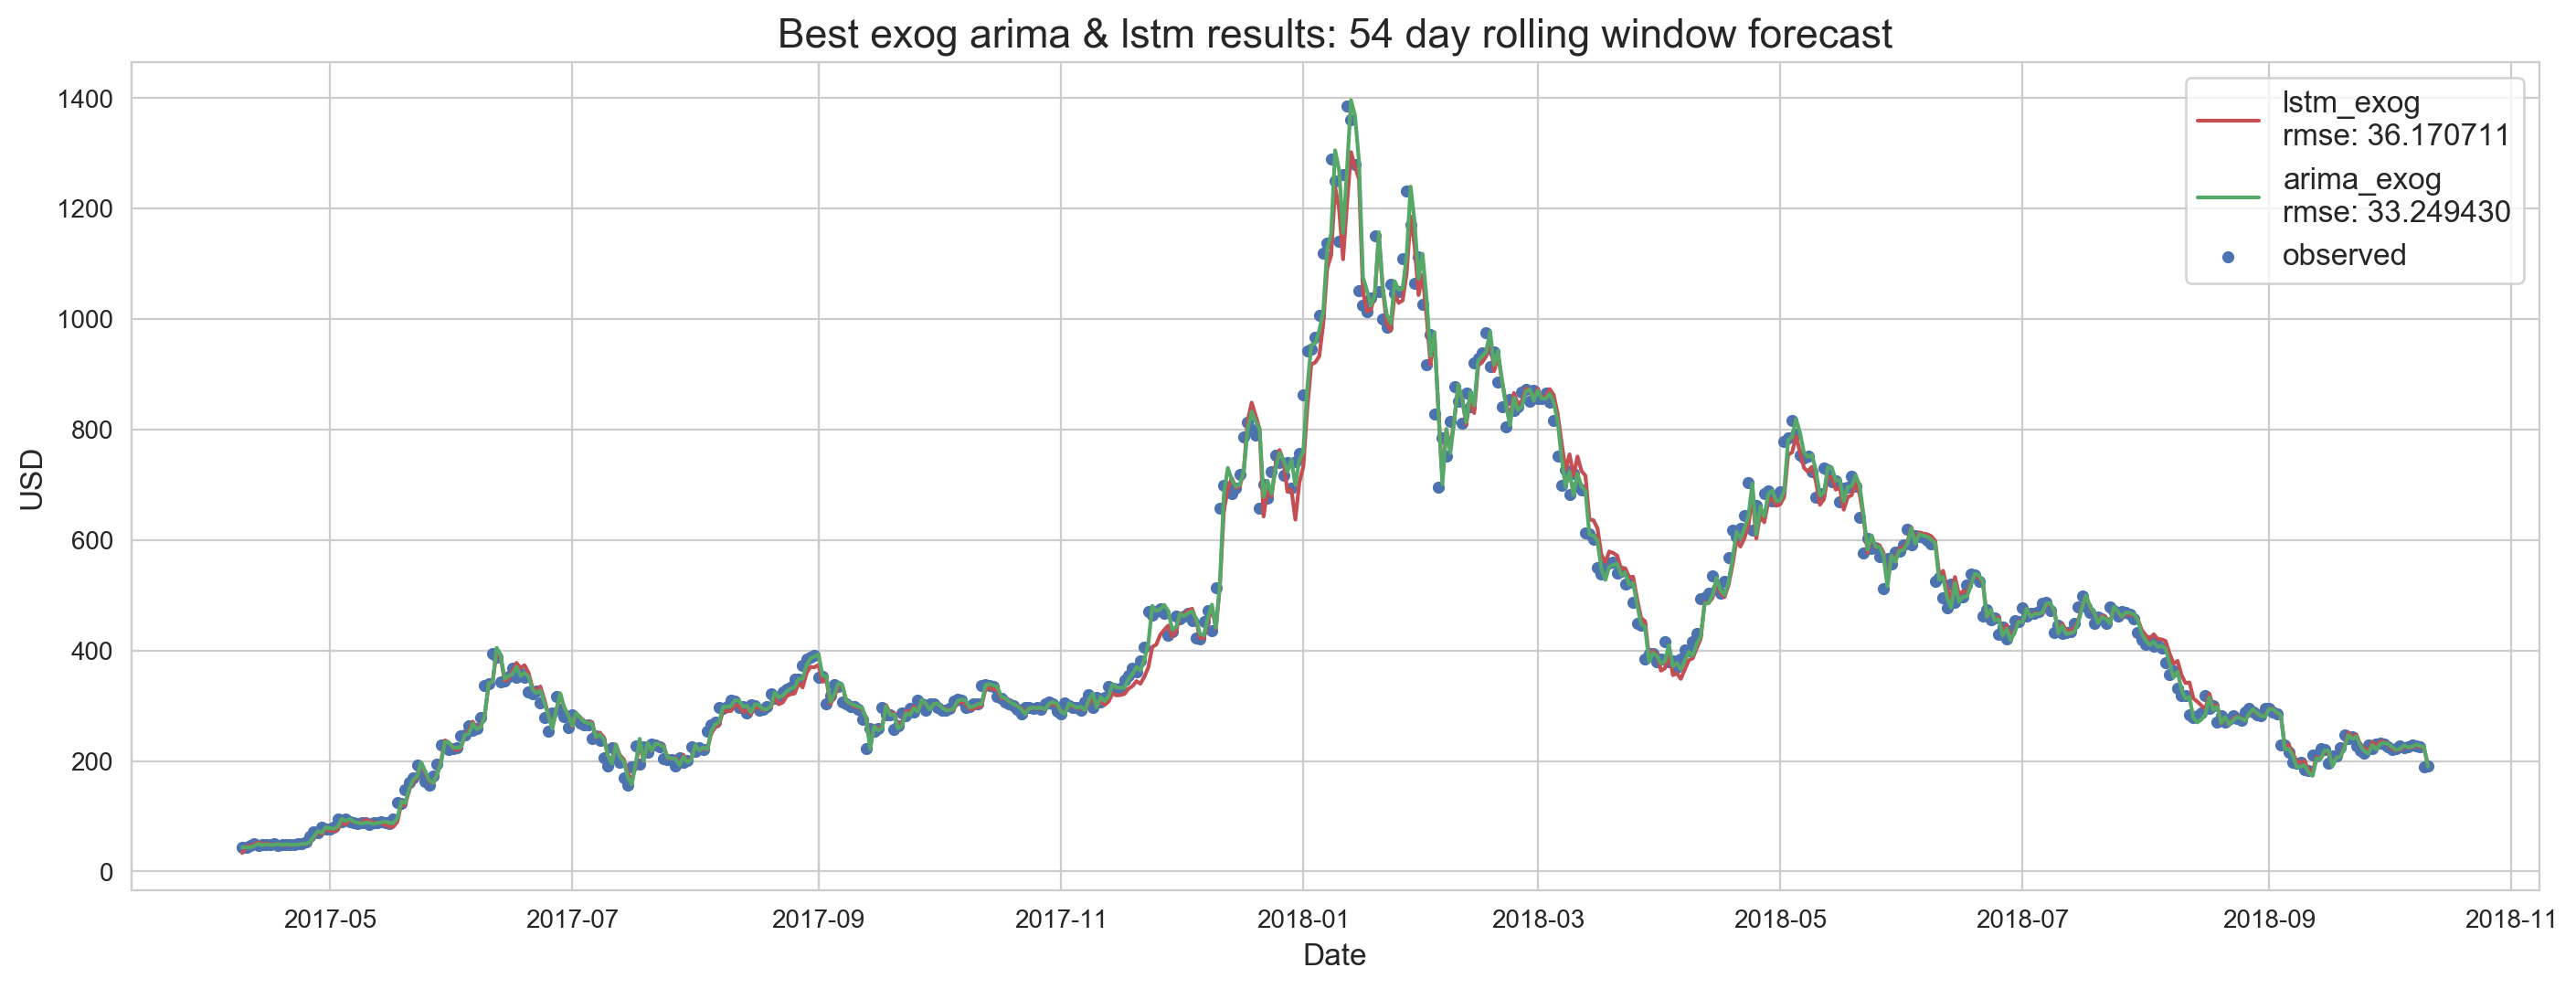

In [180]:
# best arima exog vs. best lstm exog
best_arima_exog = exog_arima_results['eth_volumefrom']
best_lstm_exog = lstm_results_dict['Adamaxlrxrp']

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# lstm forecast
ax.plot(
    ts.eth_close[-len(best_lstm_exog):].index,
    np.array(best_lstm_exog).reshape(len(best_lstm_exog),),
    label="lstm_exog\nrmse: {:.6f}".format(lstm_rmse(best_lstm_exog)),
    c=colors[3]
)
# arima forecast
ax.plot(
    ts.eth_close[-len(best_arima_exog[0]):].index,
    best_arima_exog[0],
    label="arima_exog\nrmse: {:.6f}".format(rmse(ts.eth_close[1 + window:], best_arima_exog[0])),
    c=colors[2]
)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm_exog):].index,
    ts.eth_close.values[-len(best_lstm_exog):],
    label="observed",
    c=colors[0],
    s=14
)
#plt.setp(ax.lines, linewidth=1.5)
ax.set_title("Best exog arima & lstm results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

- Results:
    - ETH Volume (From) is the only exogenous driver that improved any model
    - The ARIMA model improved; results are consistent and reproducible
    - All LSTM RNNs lost predictive power when given the exogenous data

# 6. Summary & Conclusions

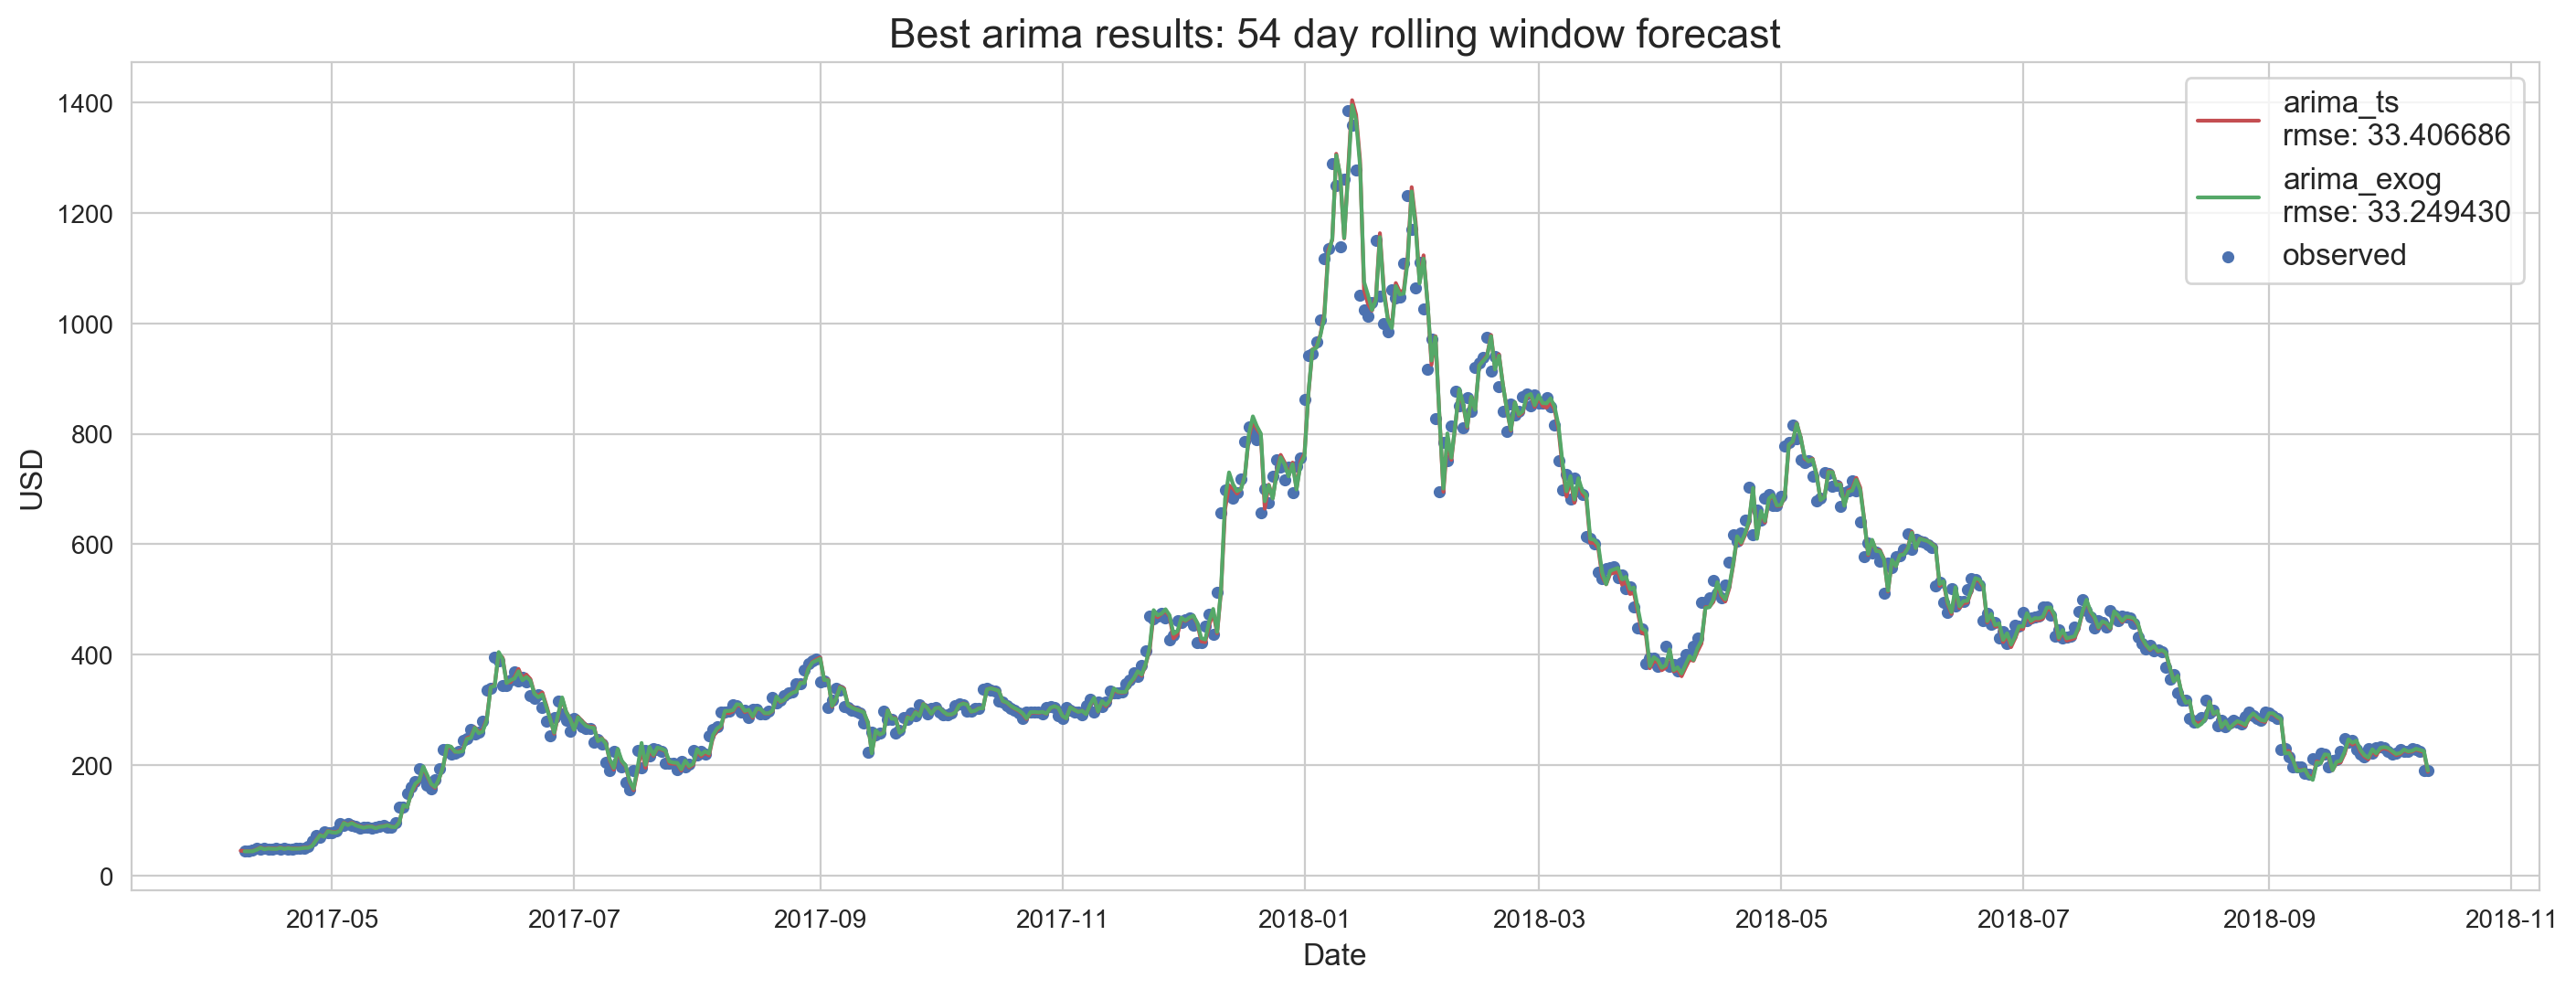

In [190]:
# arima ts vs arima exog
best_arima_exog = exog_arima_results['eth_volumefrom']
best_arima_ts = d1_fc

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# arima ts
ax.plot(
    ts.eth_close[-len(best_arima_ts[0]):].index,
    best_arima_ts[0],
    label="arima_ts\nrmse: {:.6f}".format(rmse(ts.eth_close[window:], best_arima_ts[0])),
    c=colors[3]
)
# arima exog
ax.plot(
    ts.eth_close[-len(best_arima_exog[0]):].index,
    best_arima_exog[0],
    label="arima_exog\nrmse: {:.6f}".format(rmse(ts.eth_close[1 + window:], best_arima_exog[0])),
    c=colors[2]
)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm_exog):].index,
    ts.eth_close.values[-len(best_lstm_exog):],
    label="observed",
    c=colors[0],
    s=14
)
#plt.setp(ax.lines, linewidth=1.5)
ax.set_title("Best arima results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

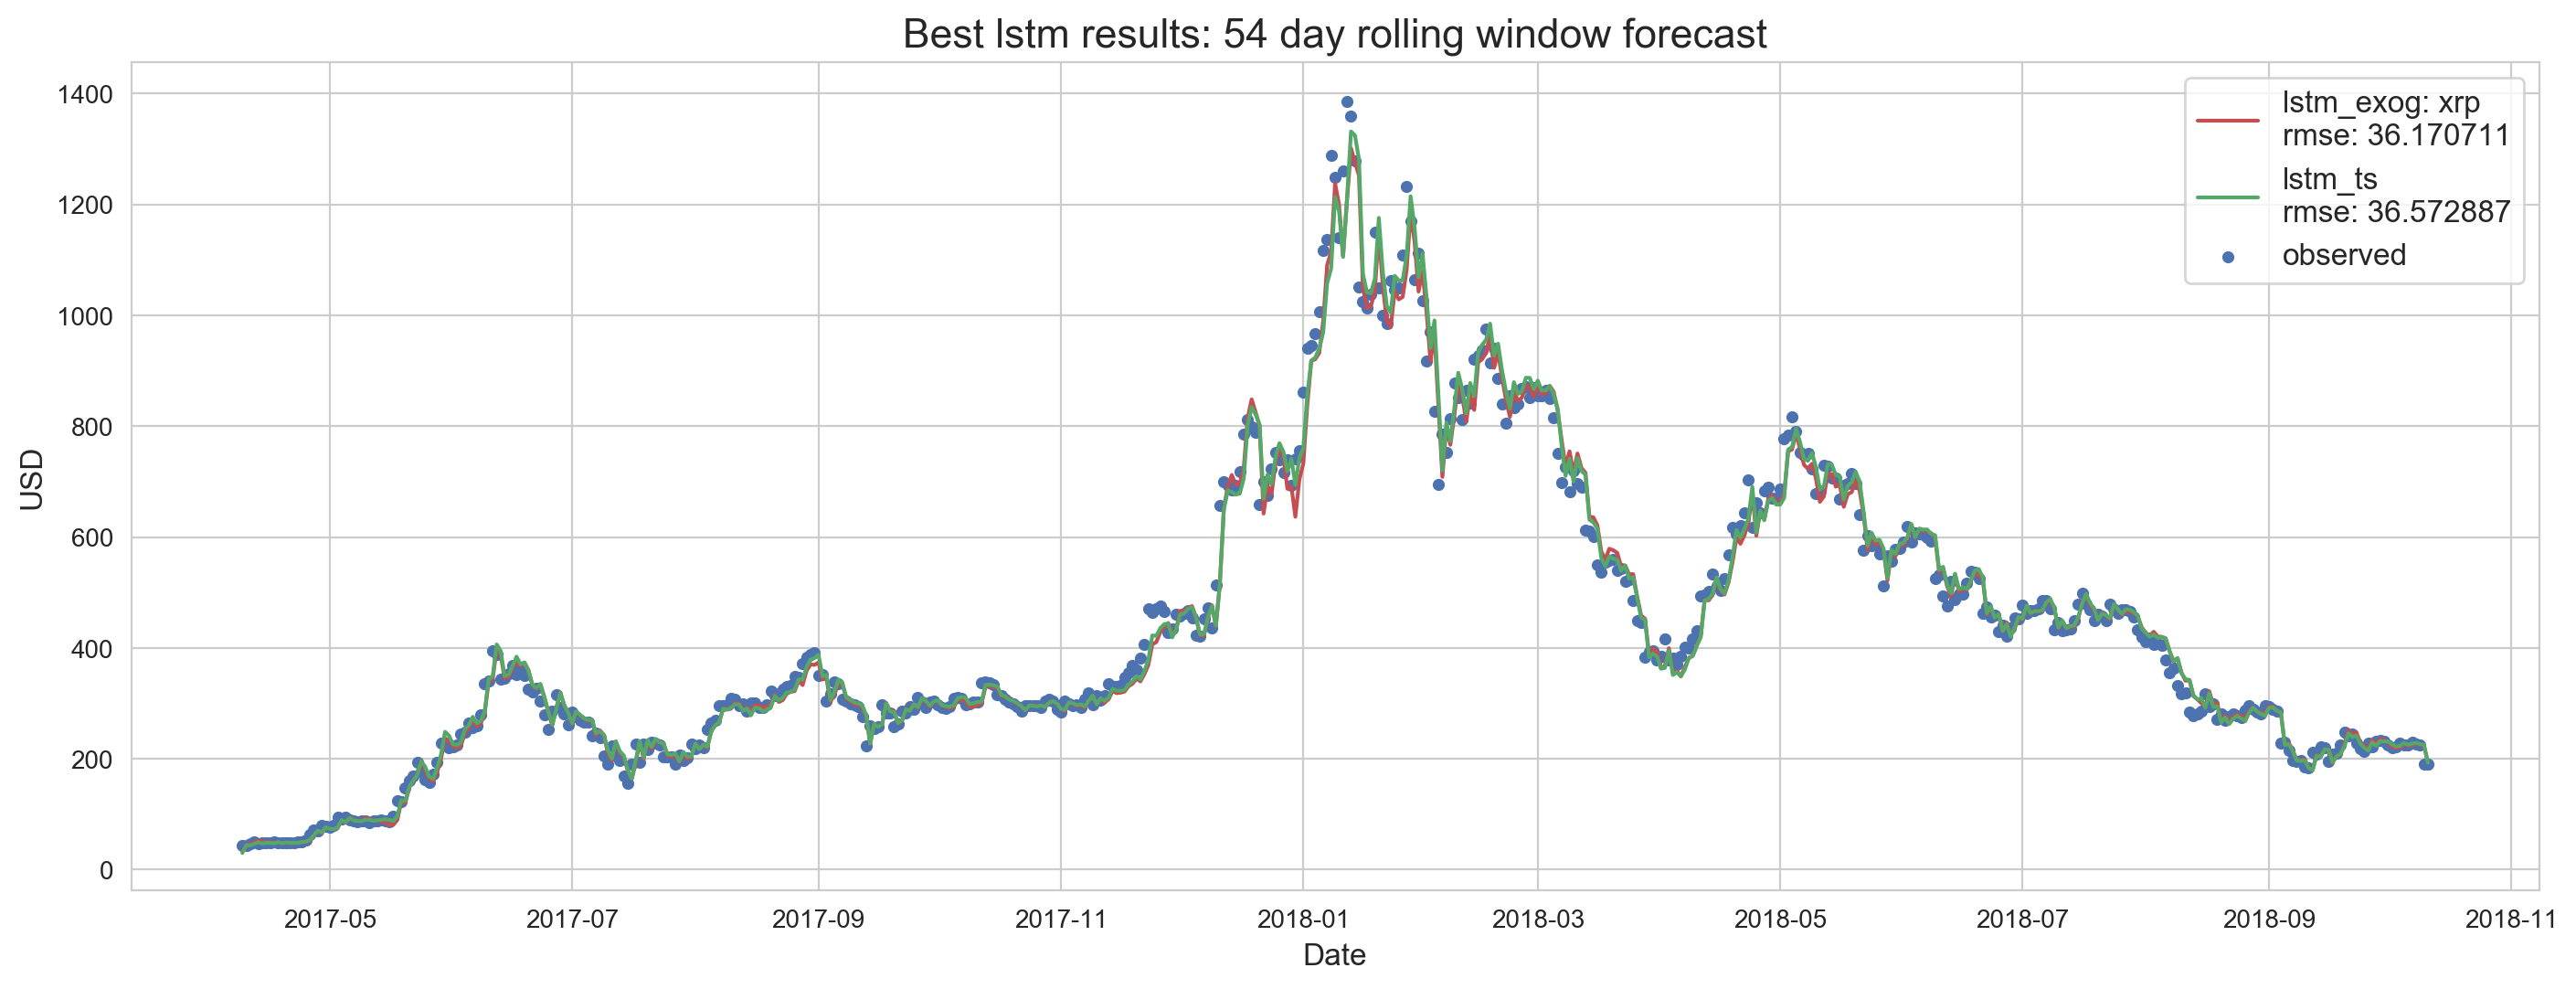

In [184]:
# lstm ts vs lstm exog
best_lstm_exog = lstm_results_dict['Adamaxlrxrp']
best_lstm_ts = lstm_results_dict['Adamaxlr0.002']

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# lstm exog forecast
ax.plot(
    ts.eth_close[-len(best_lstm_exog):].index,
    np.array(best_lstm_exog).reshape(len(best_lstm_exog),),
    label="lstm_exog: xrp\nrmse: {:.6f}".format(lstm_rmse(best_lstm_exog)),
    c=colors[3]
)
# lstm ts forecast
ax.plot(
    ts.eth_close[-len(best_lstm_ts):].index,
    np.array(best_lstm_ts).reshape(len(best_lstm_ts)),
    label="lstm_ts\nrmse: {:.6f}".format(lstm_rmse(best_lstm_ts)),
    c=colors[2]
)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm_exog):].index,
    ts.eth_close.values[-len(best_lstm_exog):],
    label="observed",
    c=colors[0],
    s=14
)
ax.set_title("Best lstm results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

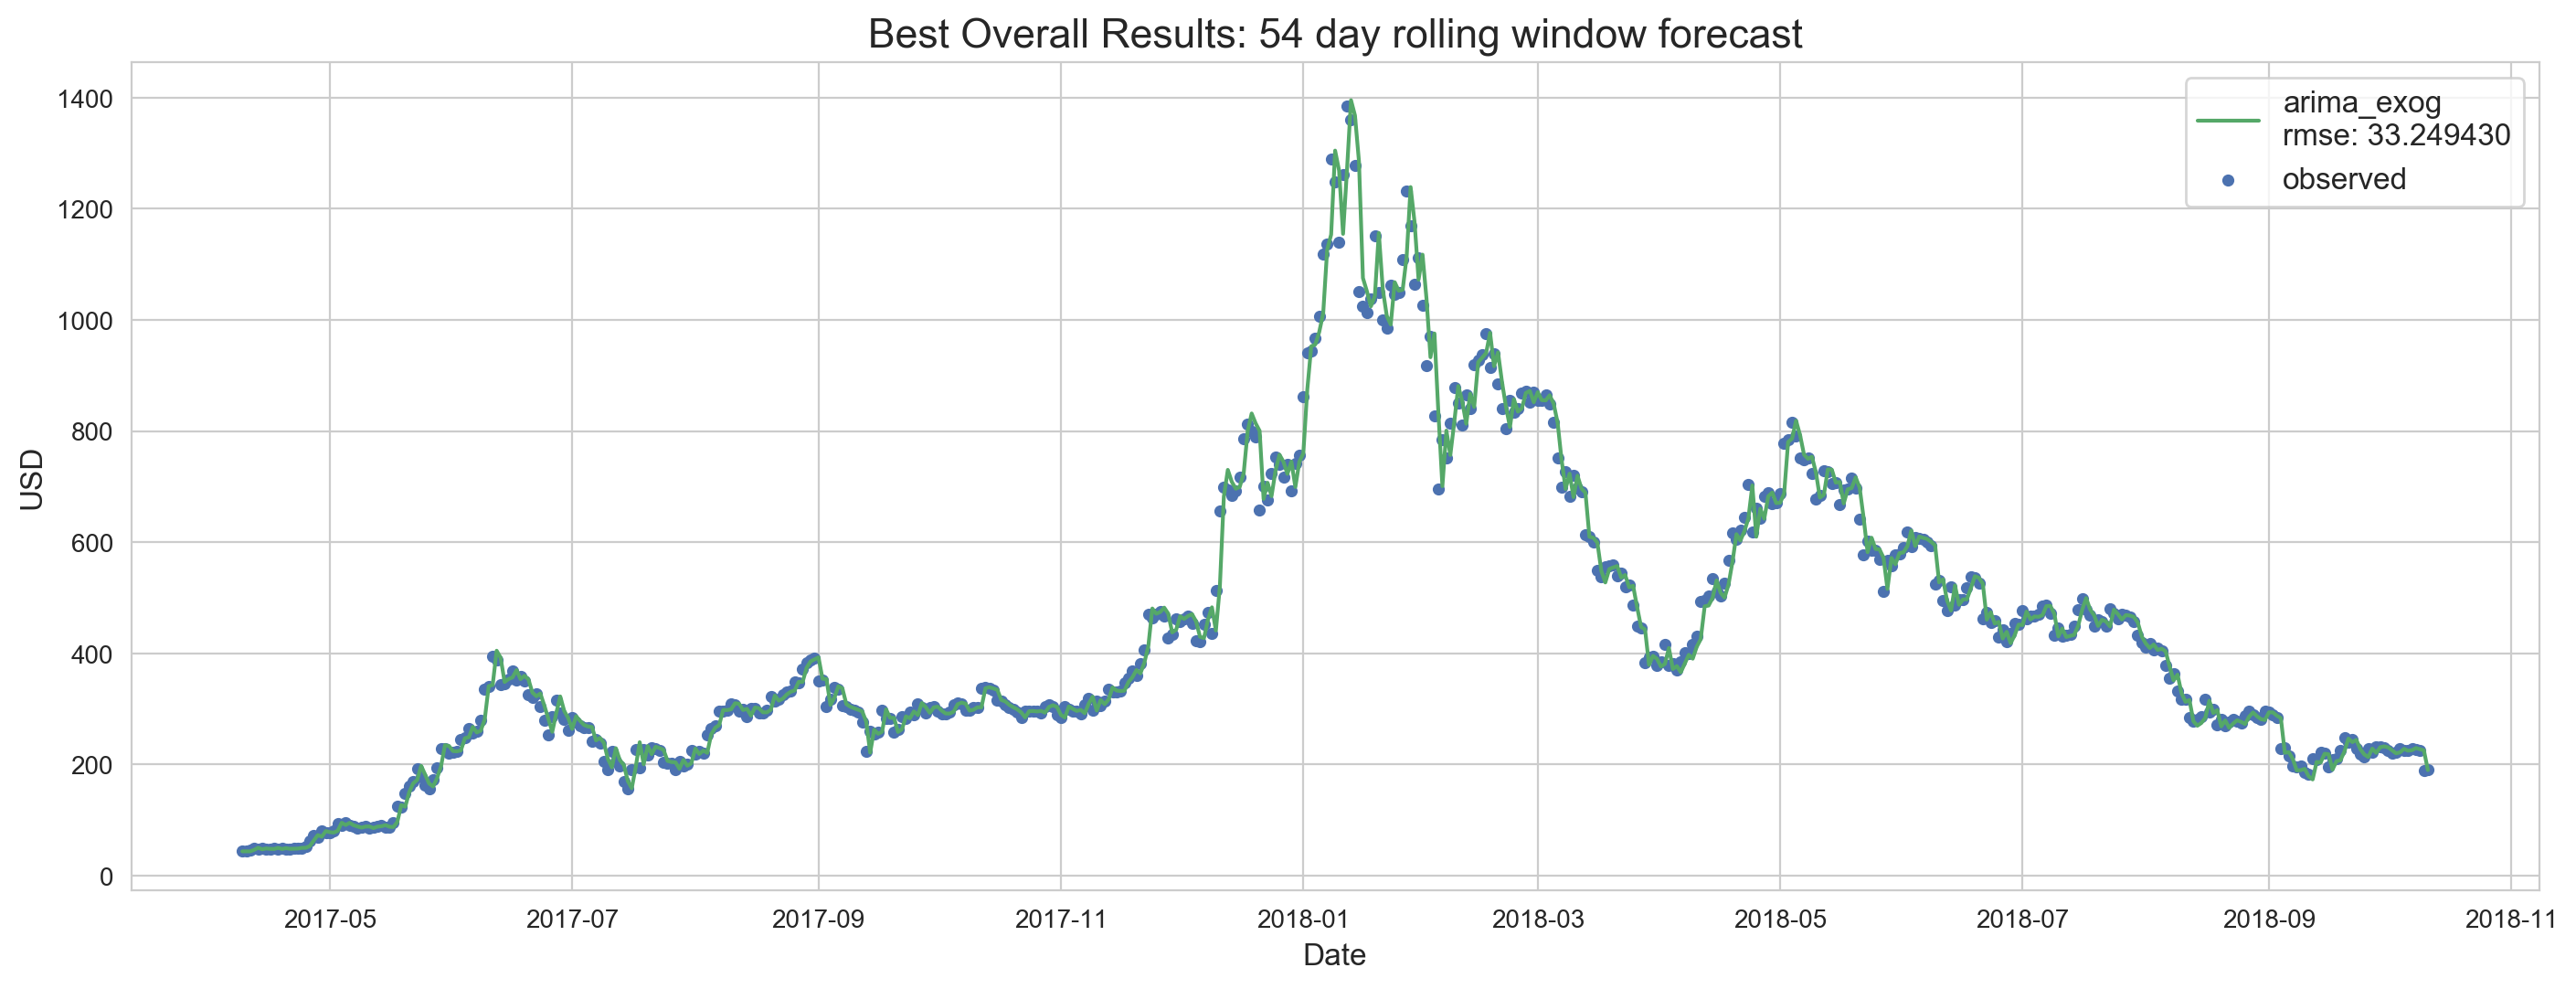

In [192]:
# best arima exog vs. best lstm exog
best_arima_exog = exog_arima_results['eth_volumefrom']
best_lstm_exog = lstm_results_dict['Adamaxlrxrp']

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# lstm forecast
#ax.plot(
#    ts.eth_close[-len(best_lstm_exog):].index,
#    np.array(best_lstm_exog).reshape(len(best_lstm_exog),),
#    label="lstm_exog\nrmse: {:.6f}".format(lstm_rmse(best_lstm_exog)),
#    c=colors[3]
#)
# arima forecast
ax.plot(
    ts.eth_close[-len(best_arima_exog[0]):].index,
    best_arima_exog[0],
    label="arima_exog\nrmse: {:.6f}".format(rmse(ts.eth_close[1 + window:], best_arima_exog[0])),
    c=colors[2]
)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm_exog):].index,
    ts.eth_close.values[-len(best_lstm_exog):],
    label="observed",
    c=colors[0],
    s=14
)
#plt.setp(ax.lines, linewidth=1.5)
ax.set_title("Best Overall Results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()